# Stochastic Expansion and Approximation Methods
## Kai Chang

This notebook focuses on the use of stochastic expansions and approximation methods to solve a partial differential equation (PDE) with uncertain coefficients and boundary conditions. We will implement a few methods and assess how error depends on a variety of truncation orders and on sample size.  We also xperiment with alternative ways of computing global sensitivity indices. 


In [1]:
import numpy as np
from scipy.stats import multivariate_normal as mvn 
import scipy as sp 
from scipy.special import roots_legendre  
from scipy.linalg import eigh 

# Plotting settings
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amssymb}')
import seaborn as sns
sns.set()

## Hermite Approximation of a Non-Gaussian Process

Let us define $Y: \mathcal{D} \times \Omega \rightarrow \mathbb{R}$ as the 1-dimensional Gaussian Process of interest, where $\mathcal{D}=[0,1]$, $C\left(x_1, x_2\right)=\sigma_Y^2 \exp \left(-\frac{1}{a}\left(\frac{\left|x_1-x_2\right|}{\ell}\right)^a\right)$ is the covariance function with parameters $ \ell=0.3 \text {, } \sigma_Y^2=0.3 \text {, } a=1.0$, and $\mathbb{E}[Y(x, \omega)]=1.0$ is the mean function. The covariance function and mean function are implemented below.  

In [2]:
def cov(x, xprime=None, var=0.3, l=0.3, a=1.):
    """ 
    A Particular GP Covariance

    x: vector of input points, (n,)
    xprime : another vector of input points
    """
    if xprime is None:
        grid = np.meshgrid(x,x, indexing='ij')
    else:
        grid = np.meshgrid(x, xprime, indexing='ij')
        
    x1 = grid[0]
    x2 = grid[1]
    return var*np.exp(-1/a * np.power(np.abs(x1-x2) / l, a))

def mean(x):
    """ 
    A Particular GP Mean Function

    x: vector of input points, (n,)
    """
    n = x.shape[0]
    return np.ones((n,))

Define $C\left(x, Z^{\prime}\right)=\operatorname{Cov}\left[Y(x, \omega), Y\left(Z^{\prime}, \omega\right)\right]$ as the covariance function of the stochastic process of interest. The Karhunen-Loève (K-L) expansion of a stochastic process reads
$$
Y(x,w) = \mu(x)+\sum_{i=1}^{\infty} \sqrt{\lambda_i} \psi_i(x) Z_i(\omega)
$$
where $\mu(x)=\mathbf{E}[Y(x, \omega)]$ is the mean function, and $\psi_i(x)$ and $\lambda_i$ are the (orthogonal) eigenfunctions and eigenvalues of the following eigenvalue problem
$$
\begin{align*}
& \int_D C\left(s, s^{\prime}\right) \psi_i\left(s^{\prime}\right) d s^{\prime}=\lambda_i \psi_i(s), \\
& \quad\left\{\lambda_i\right\}_{i=1}^{\infty} \geq 0, \\
& \quad\left\{\psi_i\right\}_{i=1}^{\infty} \text { orthonormal on } \mathcal{D}.
\end{align*}
$$
It can then be shown that $Z_i$ are mutually uncorrelated, zero-mean, and unit-variance random variables. In particular, for a Gaussian Process, each $Z_i$ is a standard Gaussian random variable, which we denote as $Z_i \sim \mathcal{N}(0,1)$.

First, we wish to construct a Karhunen-Loève (K-L) expansion of $Y(x, \omega)$. 

To compute the eigenfunctions and eigenvalues for the K-L expansion of the stochastic process of interest, we employ the Nyström Method. In essense, the Nyström Method allows us to compute the $n$-term K-L expansion of $Y(x, \omega)$, which reads
$$
Y^n(x,w) = \mu(x)+\sum_{i=1}^{n} \sqrt{\lambda_i} \psi_i(x) Z_i(\omega),
$$
where the eigenfunction-eigenvalue pairs are computed by solving a (symmetric positive definite) matrix eigenvalue problem as discussed in the lecture. The Nyström Method also provides a way to evaluate the stochastic process at any point in the domain by using the accompanying interpolation formula. Suppose the eigenvalues are sorted as $\lambda_1\geq\lambda_2\geq\ldots\geq\lambda_n$, and the eigenfunctions are sorted accordingly. Then the $r$-term truncated K-L expansion reads
$$
Y^{n,r}(x,w) = \mu(x)+\sum_{i=1}^{r} \sqrt{\lambda_i} \psi_i(x) Z_i(\omega),
$$
which we will call the $r$-term truncated $n$-term K-L expansion.

A crucial part of the Nyström method is a quadrature rule. Here, we use the Gauss-Legendre quandrature rule, which is implemented below. 

In [3]:
def glrule(n, a, b):
    """ 
    customized Gauss-Legendre rule on [a,b] with n points

    Input:
        n : number of nodes
        a : left end of interval
        b : right end of interval

    Output:
        x : sample points on [a,b]
        w : weights
        mu : sum of the weights
        integrate : a function to integrate a function with respect to the nodes on [a,b]
    """
    nodes,w = roots_legendre(n)

    # shift nodes 
    nodes = 0.5*(nodes + 1)*(b - a) + a

    # scaled quadrature rule
    integrate = lambda f : np.sum(w * f(nodes)) * 0.5 * (b-a)

    return nodes,w,integrate

The Nyström Method is implemented accordingly below, which returns the Legendre nodes, approximate eigenvalues and sampled approximate eigenfunctions, and a function to evaluate the approximate eigenfunctions on arbitrary grids in the domain of interest by using the interpolation scheme given by the Nyström method. 

In [4]:
def nystrom(n, a=0, b=1.):
    """ 
    The Nyström Method
    """

    nodes,w, _ = glrule(n,a,b)

    # Form symmetrized eigenvalue problem (Not an efficient implementation!)
    w_sqrt = np.sqrt(w)
    C = cov(nodes)
    Csym = w_sqrt.reshape(-1,1) * C * w_sqrt.reshape(1,-1) 

    # sort in descending order
    eigval, eigvec = eigh(Csym)
    idx = eigval.argsort()[::-1]
    eigval = eigval[idx]
    eigvec = eigvec[:,idx]  

    # scale eigvec back to psi
    psi = eigvec / w_sqrt.reshape(-1,1)

    def eval_psi(xgrid):
        """ 
        Evaluate eigenfunctions on x using the quadrature rule with the Nystrom method

        """
        C = cov(nodes, xgrid)
        C = C.T
        psi_full = C @ (psi * w.reshape(-1,1)) / eigval.reshape(1,-1)
        return psi_full

    return nodes, eigval, psi, eval_psi

In the following experiment, we choose $n=1000$, compute the $n$-term K-L expansion of the stochastic process (without truncation) $Y^n(x,w)$ as discussed above, and evaluate the approximate eigenfunctions on a uniform grid of $1000$ nodes on $[0,1]$. We plot the approximate eigenvalues, sorted in descending order, on the left, and plot the (sampled) eigenfunctions corresponding to the 10 largest approximate eigenvalues on the right.

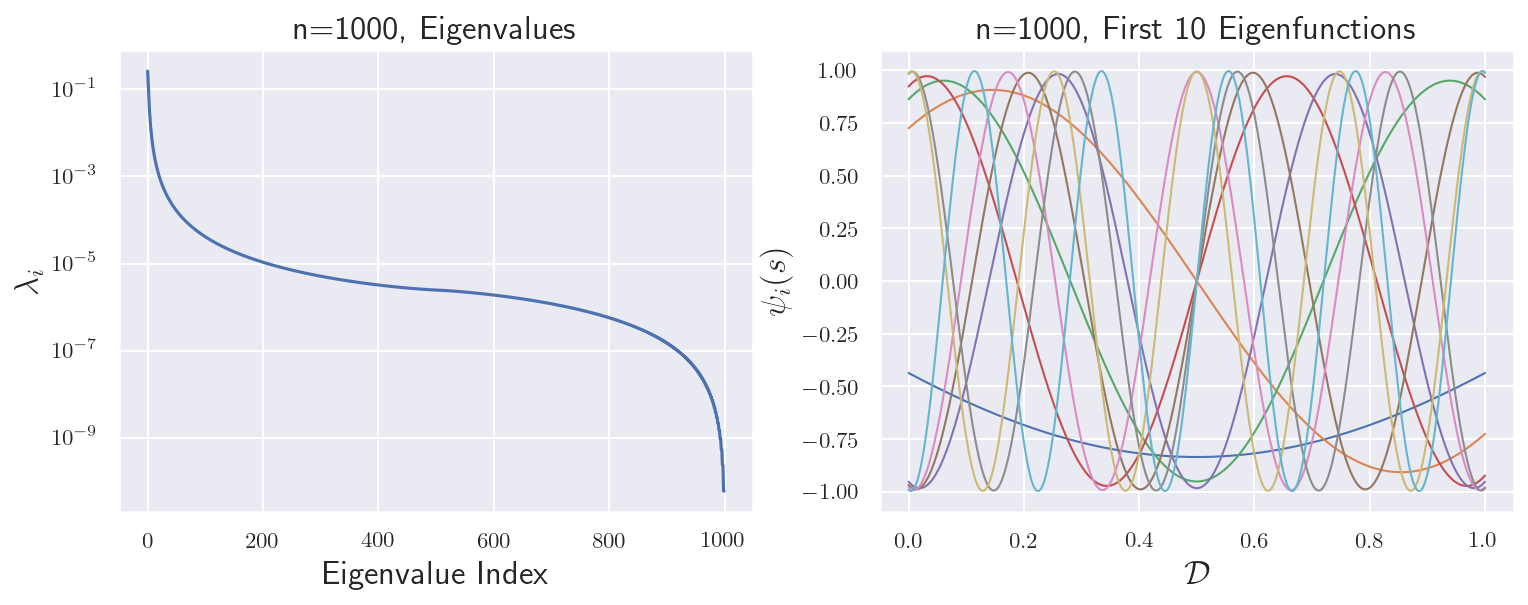

In [5]:
import matplotlib.pyplot as plt

n = 1000
nodes, eigval, eigvec, eval_psi = nystrom(n)
xgrid = np.linspace(0,1,1001)
psi_full = eval_psi(xgrid)

fig, ax = plt.subplots(1,2,figsize=(12,4), dpi=150)
ax[0].semilogy(eigval)
ax[0].set_xlabel("Eigenvalue Index", fontsize=16)
ax[0].set_ylabel(r"$\lambda_i$", fontsize=16)
ax[0].set_title(f"n={n}, Eigenvalues", fontsize=16)

ax[1].plot(xgrid, psi_full[:,:10], linewidth=1.)
ax[1].set_xlabel(r"$\mathcal{D}$", fontsize=16)
ax[1].set_ylabel(r"$\psi_i(s)$", fontsize=16)
ax[1].set_title(f"n={n}, First 10 Eigenfunctions", fontsize=16)

print()

Next, we want to investigate how large of an $n$ is needed to capture 99% of the point-wise variance of $Y$ integrated over $[0,1]$. Note that by assumption, we have $ \text{Var}(Y(x,\omega)) = 0.3 $ for all $x \in [0,1]$. According to the K-L expansion, we have 
$$ 
\text{Var}(Y^n(x,\omega)) = \sum_{i=1}^n \psi_i(x)^2\lambda_i.
$$ 
Since we know how to evaluate $\psi_i(x)$ for any $x\in[0,1]$ and any $i$, we can easily compute the pointwise variance of the uniform grid of 1000 nodes we used when plotting the eigenfunctions above. The integrated variance is then computed by using the trapezoid rule on the uniform grid and compared to 0.3, the true variance. 

The result is reported below for $n$ ranging from 10 to 140. We see that when $n$ gets to 140, more than 99% of the variance is captured.

In [6]:
import pandas as pd
from IPython.display import display

def point_var(eigval, psi_full):
    """ 
    Compute point-wise variance over spatial domain
    """
    var = np.power(psi_full,2) * eigval.reshape(1,-1)
    var = np.sum(var, axis=1)
    return var

def total_var(xgrid, eigval, psi_full):
    """ 
    Compute the integrated variance of Nyström-truncated KL Expanded GP over the spatial domain
    Use equi-distant trapezoidal rule 

    Input:
        eigval: eigenvalues with Nyström method
    """
    var = point_var(eigval, psi_full)
    return np.trapz(var, x=xgrid)

nlist = np.arange(10,141,10)
xgrid = np.linspace(0,1,1001)
err = []
for n in nlist:
    # nystrom method for truncated K-L Expansion
    _, eigval, _, eval_psi = nystrom(n)

    # evaluate eigenfunction on xgrid
    psi_full = eval_psi(xgrid)

    # compute integrated variance on [0,1] with quadrature rule on xgrid
    var = total_var(xgrid, eigval, psi_full)

    # append variance percentage
    err.append(var / .3)

d = {
    'n' : np.round(nlist,0),
    'Variance Percentage' : np.round(err,4)
}
df = pd.DataFrame(d)
display(df.transpose())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
n,10.0000,20.0000,30.0000,40.0000,50.0000,60.0000,70.0000,80.000,90.0000,100.0000,110.0000,120.0000,130.0000,140.0000
Variance Percentage,0.8715,0.9335,0.9552,0.9662,0.9729,0.9774,0.9806,0.983,0.9849,0.9864,0.9876,0.9886,0.9895,0.9902


In the following experiment, we investigate the effect of varying $n$, the total number of K-L modes, on the realizations of the target Gaussian Process. We choose $n$ among $\{20,40,80,160,320,640\}$, and for each of them, we plot a sampled Gaussian Process evaluated at a uniform grid of 1000 nodes on $[0,1]$. From the plot, we see that as more K-L modes are used, the sampled process gets more wiggled (less and less smoother).

We remark that in the following sampling code, we also provide an argument `r` to be used later. `r` represents the number of K-L modes corresponding to the larger eigenvalues that will be kept after truncation. `r`, if not provided explicitly, is assumed to equal `n`. 

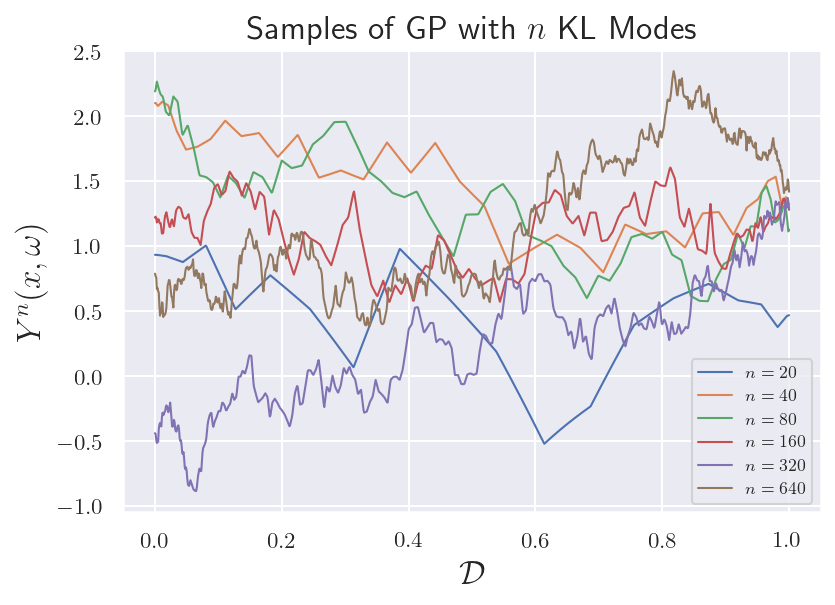

In [7]:
def sample_kl(n, s, xgrid=np.linspace(0,1,1001), r=None):
    """ 
    draw s samples from GP with n KL modes at xgrid

    Input:
        n: number of KL-modes in total
    """
    nodes, eigval, eigvec, eval_psi = nystrom(n)

    # evaluate eigenfunction on uniform grid
    psi_full = eval_psi(xgrid)

    # mean function
    mu = mean(xgrid)

    # draw sample
    ev_sqrt = np.sqrt(eigval)
    temp = psi_full * ev_sqrt.reshape(1,-1)
    if r is not None:
        temp = temp[:, :r]
        z = np.random.randn(s,r) # modes Z_i
    else:
        z = np.random.randn(s,n) # modes Z_i
    temp = np.einsum('Nn,sn->Ns', temp, z)
    samples = mu.reshape(-1,1) + temp

    return samples.squeeze()

# draw samples with a range of n
np.random.seed(1)
nlist = [20*2**k for k in range(6)]
xgrid = np.linspace(0,1,1001)
plt.figure(figsize=(6,4), dpi=150)
for n in nlist:
    sample = sample_kl(n,1,xgrid)
    lbl = fr"$n = {n}$"
    plt.plot(xgrid, sample, label=lbl, linewidth=1)

plt.title(r"Samples of GP with $n$ KL Modes", fontsize=16)
plt.xlabel(r"$\mathcal{D}$", fontsize=16)
plt.ylabel(r"$Y^n(x,\omega)$", fontsize=16)
plt.legend(prop={'size': 8})
print()

In the next experiment, we aim to compare the analytic variance of $Y^n(x,\omega)$ (without truncation), the formula of which has been presented above, and the Monte-Carlo-approximated variance of $Y^n(x,\omega)$. Note that the true variance is 0.3. The pointwise variance, either analytic or approximated, is computed over the uniform grid of 1000 nodes on $[0,1]$. For the approximated variance, we draw 1000 independent realizations of the Gaussian Process and compute the sample variance. We choose $n$ among $\{20,40,80,160,320,640\}$ and plot the results below. 

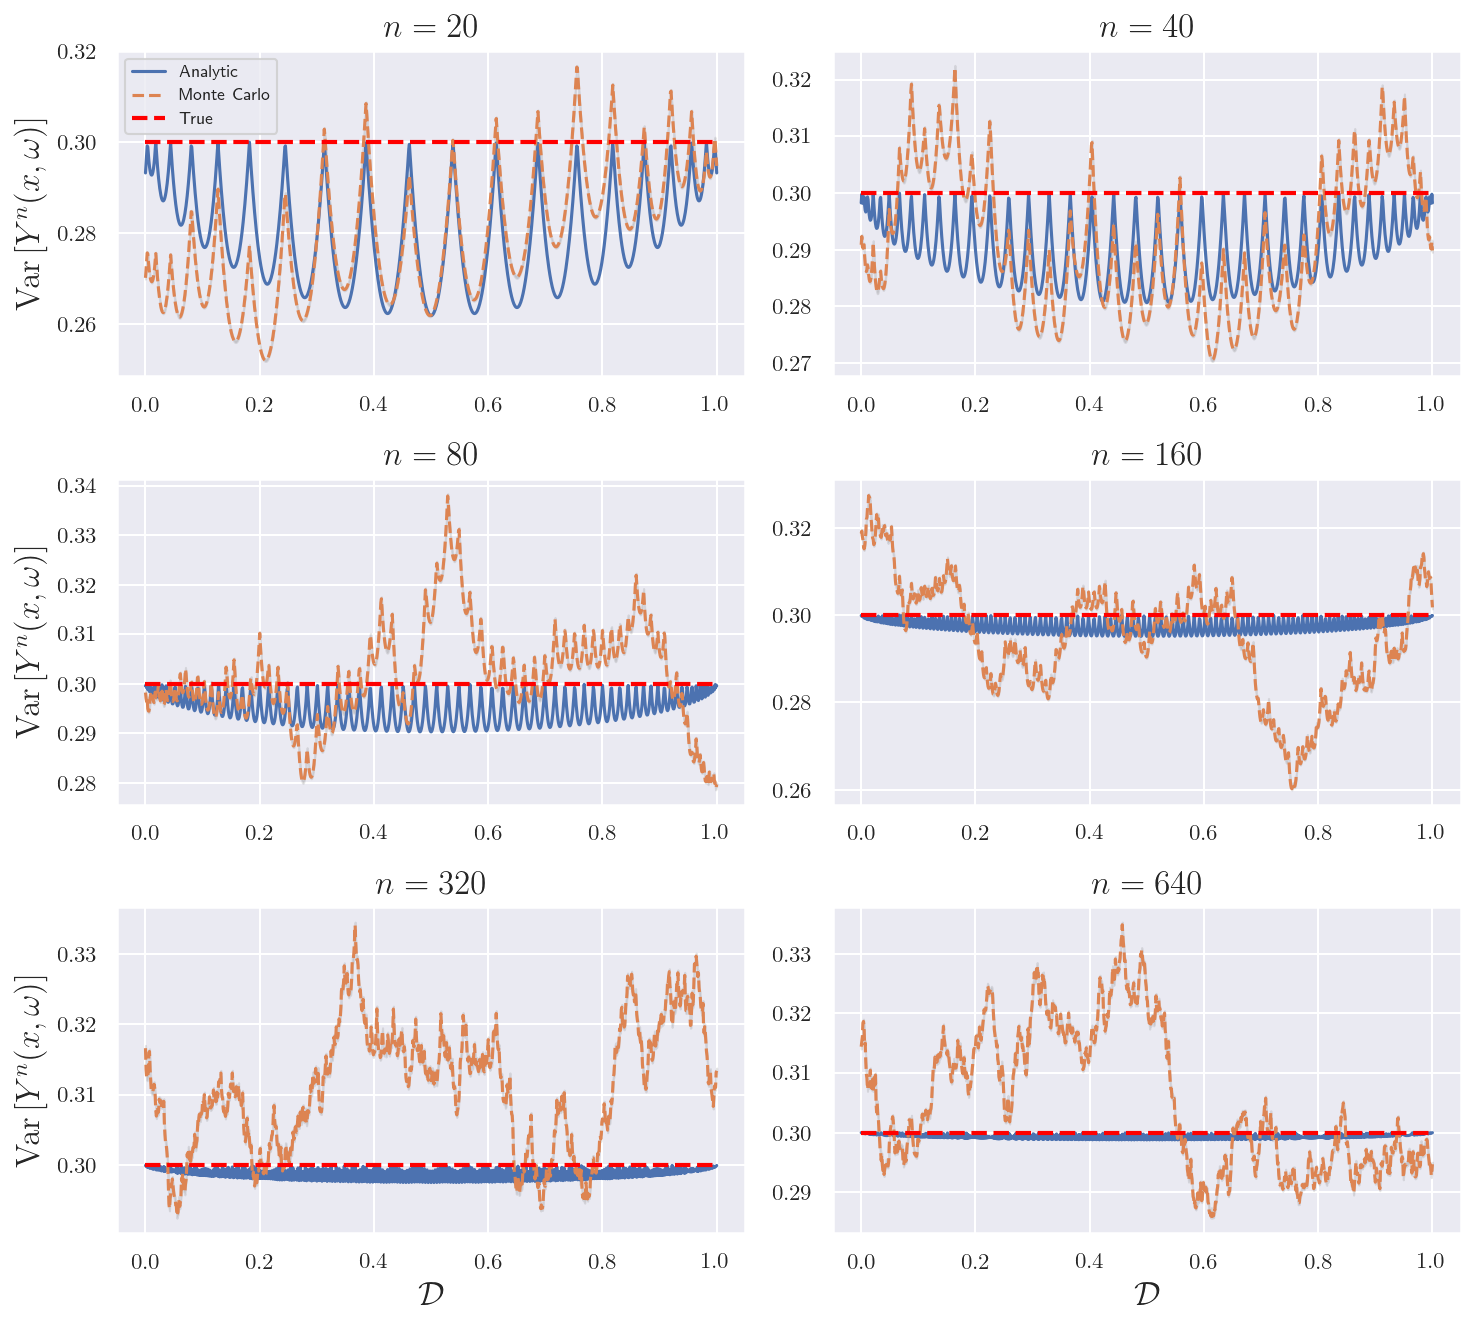

In [8]:
from matplotlib import cm 
np.random.seed(1)
nlist = [20*2**k for k in range(6)]
xgrid = np.linspace(0,1,1001)
s = 1000

fig, ax = plt.subplots(3,2, figsize = (10,9), dpi=150)
for i,n in enumerate(nlist):
    # nystrom method for truncated K-L Expansion
    _, eigval, _, eval_psi = nystrom(n)

    # evaluate eigenfunction on xgrid
    psi_full = eval_psi(xgrid)

    # analytic pointwise variance
    var_analytic = point_var(eigval, psi_full)

    # monte carlo estimator
    samples = sample_kl(n, s)
    var_mc = np.var(samples, axis=1)
    se_mc = 2*np.power(var_mc, 2) / (s-1)

    # plot
    I = i//2
    J = i%2
    ax[I,J].plot(xgrid, var_analytic, label='Analytic')
    ax[I,J].plot(xgrid, var_mc, '--', label='Monte Carlo')
    ax[I,J].hlines(y=0.3, xmin=0, xmax=1, colors='red', linestyles='--', lw=2, label="True")
    ax[I,J].fill_between(xgrid, var_mc-1.96*se_mc, var_mc+1.96*se_mc, alpha=0.2, color="gray")

    ax[I,J].set_title(fr"$n = {n}$", fontsize=16)
    if J==0:
        ax[I,J].set_ylabel(r"$\mathrm{Var}\left[Y^n(x,\omega)\right]$", fontsize=16) 
    
    if I==2:
        ax[I,J].set_xlabel(r"$\mathcal{D}$", fontsize=16)

plt.tight_layout()
ax[0,0].legend(prop={'size': 8})

<!-- ## 1.(d) Closed-Form Hermite Coefficient -->
Next we consider the random variable $K=\exp \left(b^{\top} Z+\mu\right)$ for $Z=\left(Z_1, \ldots, Z_n\right) \sim \mathcal{N}\left(0, I_n\right)$ and some vector $b \in \mathbb{R}^n$. $K$ is thus a scalar-valued log-normal random variable. We would like to create a Hermite chaos expansion of $K$ as a function of the Gaussian variables $Z: \Omega \rightarrow \mathbb{R}^n$, for a fixed $b$ and $\mu$; in other words, we want to express $K$ as $K=\sum_\alpha c_\alpha \Psi_\alpha(Z)$. 

To derive the closed-form formula for the Hermite polynomial coefficient $C_{\vec{\alpha}}$, we first consider the univariate case. Let $X$ be univariate standard Gaussian and $Y = \exp{\mu + \sigma X}$. Suppose $Y$ has chaos expansion
$$
Y(X)=\sum_{\alpha=0}^{\infty} C_\alpha \mathrm{He}_\alpha(X)
$$
where $\mathrm{He}_\alpha(\cdot)$ is the univariate Hermite polynomial of degree $\alpha$. Then 

\begin{align*}
\left\langle Y, \mathrm{He}_\alpha\right\rangle & =\int_{-\infty}^{\infty} \exp (\mu+\sigma X) \times \mathrm{He}_\alpha(X) \times \frac{1}{\sqrt{2 \pi}} \exp \left(-\frac{Z^2}{2}\right) d X \\
& =\exp \left(\mu+\frac{\sigma^2}{2}\right) \times \sigma^\alpha, 
\end{align*}

and thus,

$$
C_\alpha=\frac{\left\langle Y, \mathrm{He}_\alpha\right\rangle}{\left\langle\mathrm{He}_\alpha, \mathrm{He}_\alpha\right\rangle}=\frac{\left\langle Y, \mathrm{He}_\alpha\right\rangle}{\alpha !} = \dfrac{\exp \left(\mu+\dfrac{\sigma^2}{2}\right) \times \sigma^\alpha}{\alpha !}.
$$

Now, in the multivariate case, we have $K=\exp \left(b^{\top} Z+\mu\right)$, $Z=\left(Z_1, \ldots, Z_n\right) \sim \mathcal{N}\left(0, I_n\right)$, and $b \in \mathbb{R}^n$. Let $\boldsymbol{\alpha} = \left(\alpha_1, \alpha_2, \ldots, \alpha_n\right) \in \mathbb{N}_0^n$ be a multi-index. Suppose 

$$
\mathrm{He}_{\boldsymbol{\alpha}}(\boldsymbol{x}) = \prod_{i=1}^n \mathrm{He}_{\alpha_i}(x_i)
$$

is the multivariate Hermite polynomial, where $\boldsymbol{x} = \left(x_1, x_2, \ldots, x_n\right)$ is a dummy variable. Let 
$$
K(Z)=\sum_{{\boldsymbol{\alpha}}\geq \overrightarrow{0}}^{\infty} C_{\boldsymbol{\alpha}} \mathrm{He}_{\boldsymbol{\alpha}}(Z),
$$
be the chaos expansion of $K$ with respect to $Z$. Then, we again have 
$$
C_{\boldsymbol{\alpha}}=\frac{\left\langle K, \mathrm{He}_{\boldsymbol{\alpha}}\right\rangle}{\left\langle\mathrm{He}_{\boldsymbol{\alpha}}, \mathrm{He}_{\boldsymbol{\alpha}}\right\rangle}
$$
For the denominator, it is not hard to see that 
$$
\left\langle\mathrm{He}_{\boldsymbol{\alpha}}, \mathrm{He}_{\boldsymbol{\alpha}}\right\rangle = \prod_{i=1}^n \alpha_i ! := \boldsymbol{\alpha} !.
$$
For the numerator, following the univariate formula, we note that
$$
\begin{align*}
\left\langle K, \mathrm{He}_{\boldsymbol{\alpha}}\right\rangle &= \int_{-\infty}^{\infty} \exp (\mu+b^\top Z) \times \mathrm{He}_{\boldsymbol{\alpha}}(Z) \times \frac{1}{(2 \pi)^{n/2}} \exp \left(-\frac{Z^\top Z}{2}\right) d Z \\
&= \exp \left(\mu\right) \prod_{i=1}^n \int_{-\infty}^{\infty} \exp (b_i Z_i) \times \mathrm{He}_{\alpha_i}(Z_i) \times \frac{1}{\sqrt{2 \pi}} \exp \left(-\frac{Z_i^2}{2}\right) d Z_i \\
&= \exp \left(\mu\right) \prod_{i=1}^n \exp \left(\frac{b_i^2}{2}\right) \times b_i^{\alpha_i}\\
&= \exp \left(\mu + \frac{b^\top b}{2}\right) \prod_{i=1}^n b_i^{\alpha_i}.
\end{align*}
$$
Therefore, we have 
$$
C_{\boldsymbol{\alpha}}=\frac{\left\langle K, \mathrm{He}_{\boldsymbol{\alpha}}\right\rangle}{\left\langle\mathrm{He}_{\boldsymbol{\alpha}}, \mathrm{He}_{\boldsymbol{\alpha}}\right\rangle} = \dfrac{\exp \left(\mu + \dfrac{b^\top b}{2}\right) \prod_{i=1}^n b_i^{\alpha_i}}{\boldsymbol{\alpha} !} .
$$

<!-- ## 1.(e) PCE of $K$ -->
In the following experiment, we set $n=5$, use $\mu=1, b=\frac{1}{5}(1,2,1,2,1)$ and simulate a polynomial approximation of $K$ for different levels of truncation of the Hermite expansion. We will use a total-degree truncation $\|\boldsymbol{\alpha}\|_1 \leq p$. 

We first copy and paste the helper functions below.

In [9]:
from numpy.matlib import repmat
from scipy.special import factorial

def hermitePoly(x, degree):
    """
    psi = hermitePoly(x, degree)
    Evaluates hermite polynomials up to degree `degree` on all points x

    Arguments:
        x: points to evaluate at
        degree: highest degree to evaluate to

    Returns
        psi: (degree+1,length(x)) Evaluate degree+1 hermite polynomials on x
    """
    x = x[:]
    c = np.identity(degree+1)
    psi = np.polynomial.hermite_e.hermeval(x, c)
    return psi

def totalOrderMultiIndices(m, p):
    """
    Returns a matrix containing all multi-indices of size m of total order p
    (implementation due to prior course member)

    Parameters
    ----------
    m : int 
        Number of index components.
    p : int
        Maximum total degree (sum of degrees across a multiindex)

    Returns
    -------
    np.array
        Matrix containing multi-indices on rows.

    """
    Mk = np.zeros((1, m))
    M = Mk
    for k in range(p):
        Mk = repmat(Mk, m, 1) + np.kron(np.eye(m), np.ones((Mk.shape[0], 1)))
        Mk = np.unique(Mk, axis=0)
        M = np.vstack((M, Mk))
    return M.astype(int)


The implementation of sampling from multivariate PCE representation is presented below. It succinctly follows the mathematical derivations above.

In [10]:
def multi_herm_val(x, alpha):
    """ 
    Evaluate multi-variate hermite polynomial

    Input:
        x : points to evaluate, (s,n)
            s : number of points
            n : dimension of points
        
        alpha : degree index, (n,)
    
    Output: (s,)
    """
    s, n = x.shape
    res = np.ones((s,))
    for i,deg in enumerate(alpha):
        xi = x[:,i]
        all_deg_eval = hermitePoly(xi, deg) # (deg+1, s)
        herm_i = all_deg_eval[deg,:]
        res *= herm_i

    return res 


def c_alpha(alpha, 
            b=0.2 * np.asarray([1,2,1,2,1]), 
            mu=1.):
    """ 
    Closed-form formula of hermite coefficient

    Input:
        alpha: multi-index, (n,)
    """
    afact = np.prod(factorial(alpha))
    return np.exp(mu + b.dot(b)/2) * np.prod(np.power(b, alpha)) / afact

def sample_true(s,
                b=0.2 * np.asarray([1,2,1,2,1]), 
                mu=1.):
    """ 
    directly sample K 

    Input:
        s : number of samples
    
    Output:
        samples : (s,)
    """
    z = np.random.randn(s,5)
    exponent = np.einsum("sn,n->s", z, b) + mu
    samples = np.exp(exponent)
    return samples 

def sample_pce(p, s):
    """ 
    Sample K with polynomial chaos expansion

    Input:
        p : PCE maximum total degree
        s : number of samples

    """
    indices = totalOrderMultiIndices(5, p)
    z = np.random.randn(s,5)
    samples = np.zeros((s,))
    for alpha in indices:
        samples += c_alpha(alpha) * multi_herm_val(z, alpha)
    
    return samples 


We plot the "true" samples along with the PCE samples. The true samples are obtained by sampling $Z$ and apply $\exp{(b^\top Z + \mu)}$. We see that as $p$, the multi-index threshold, gets bigger, the distribution of the PCE samples gets closer to the true distirbution.

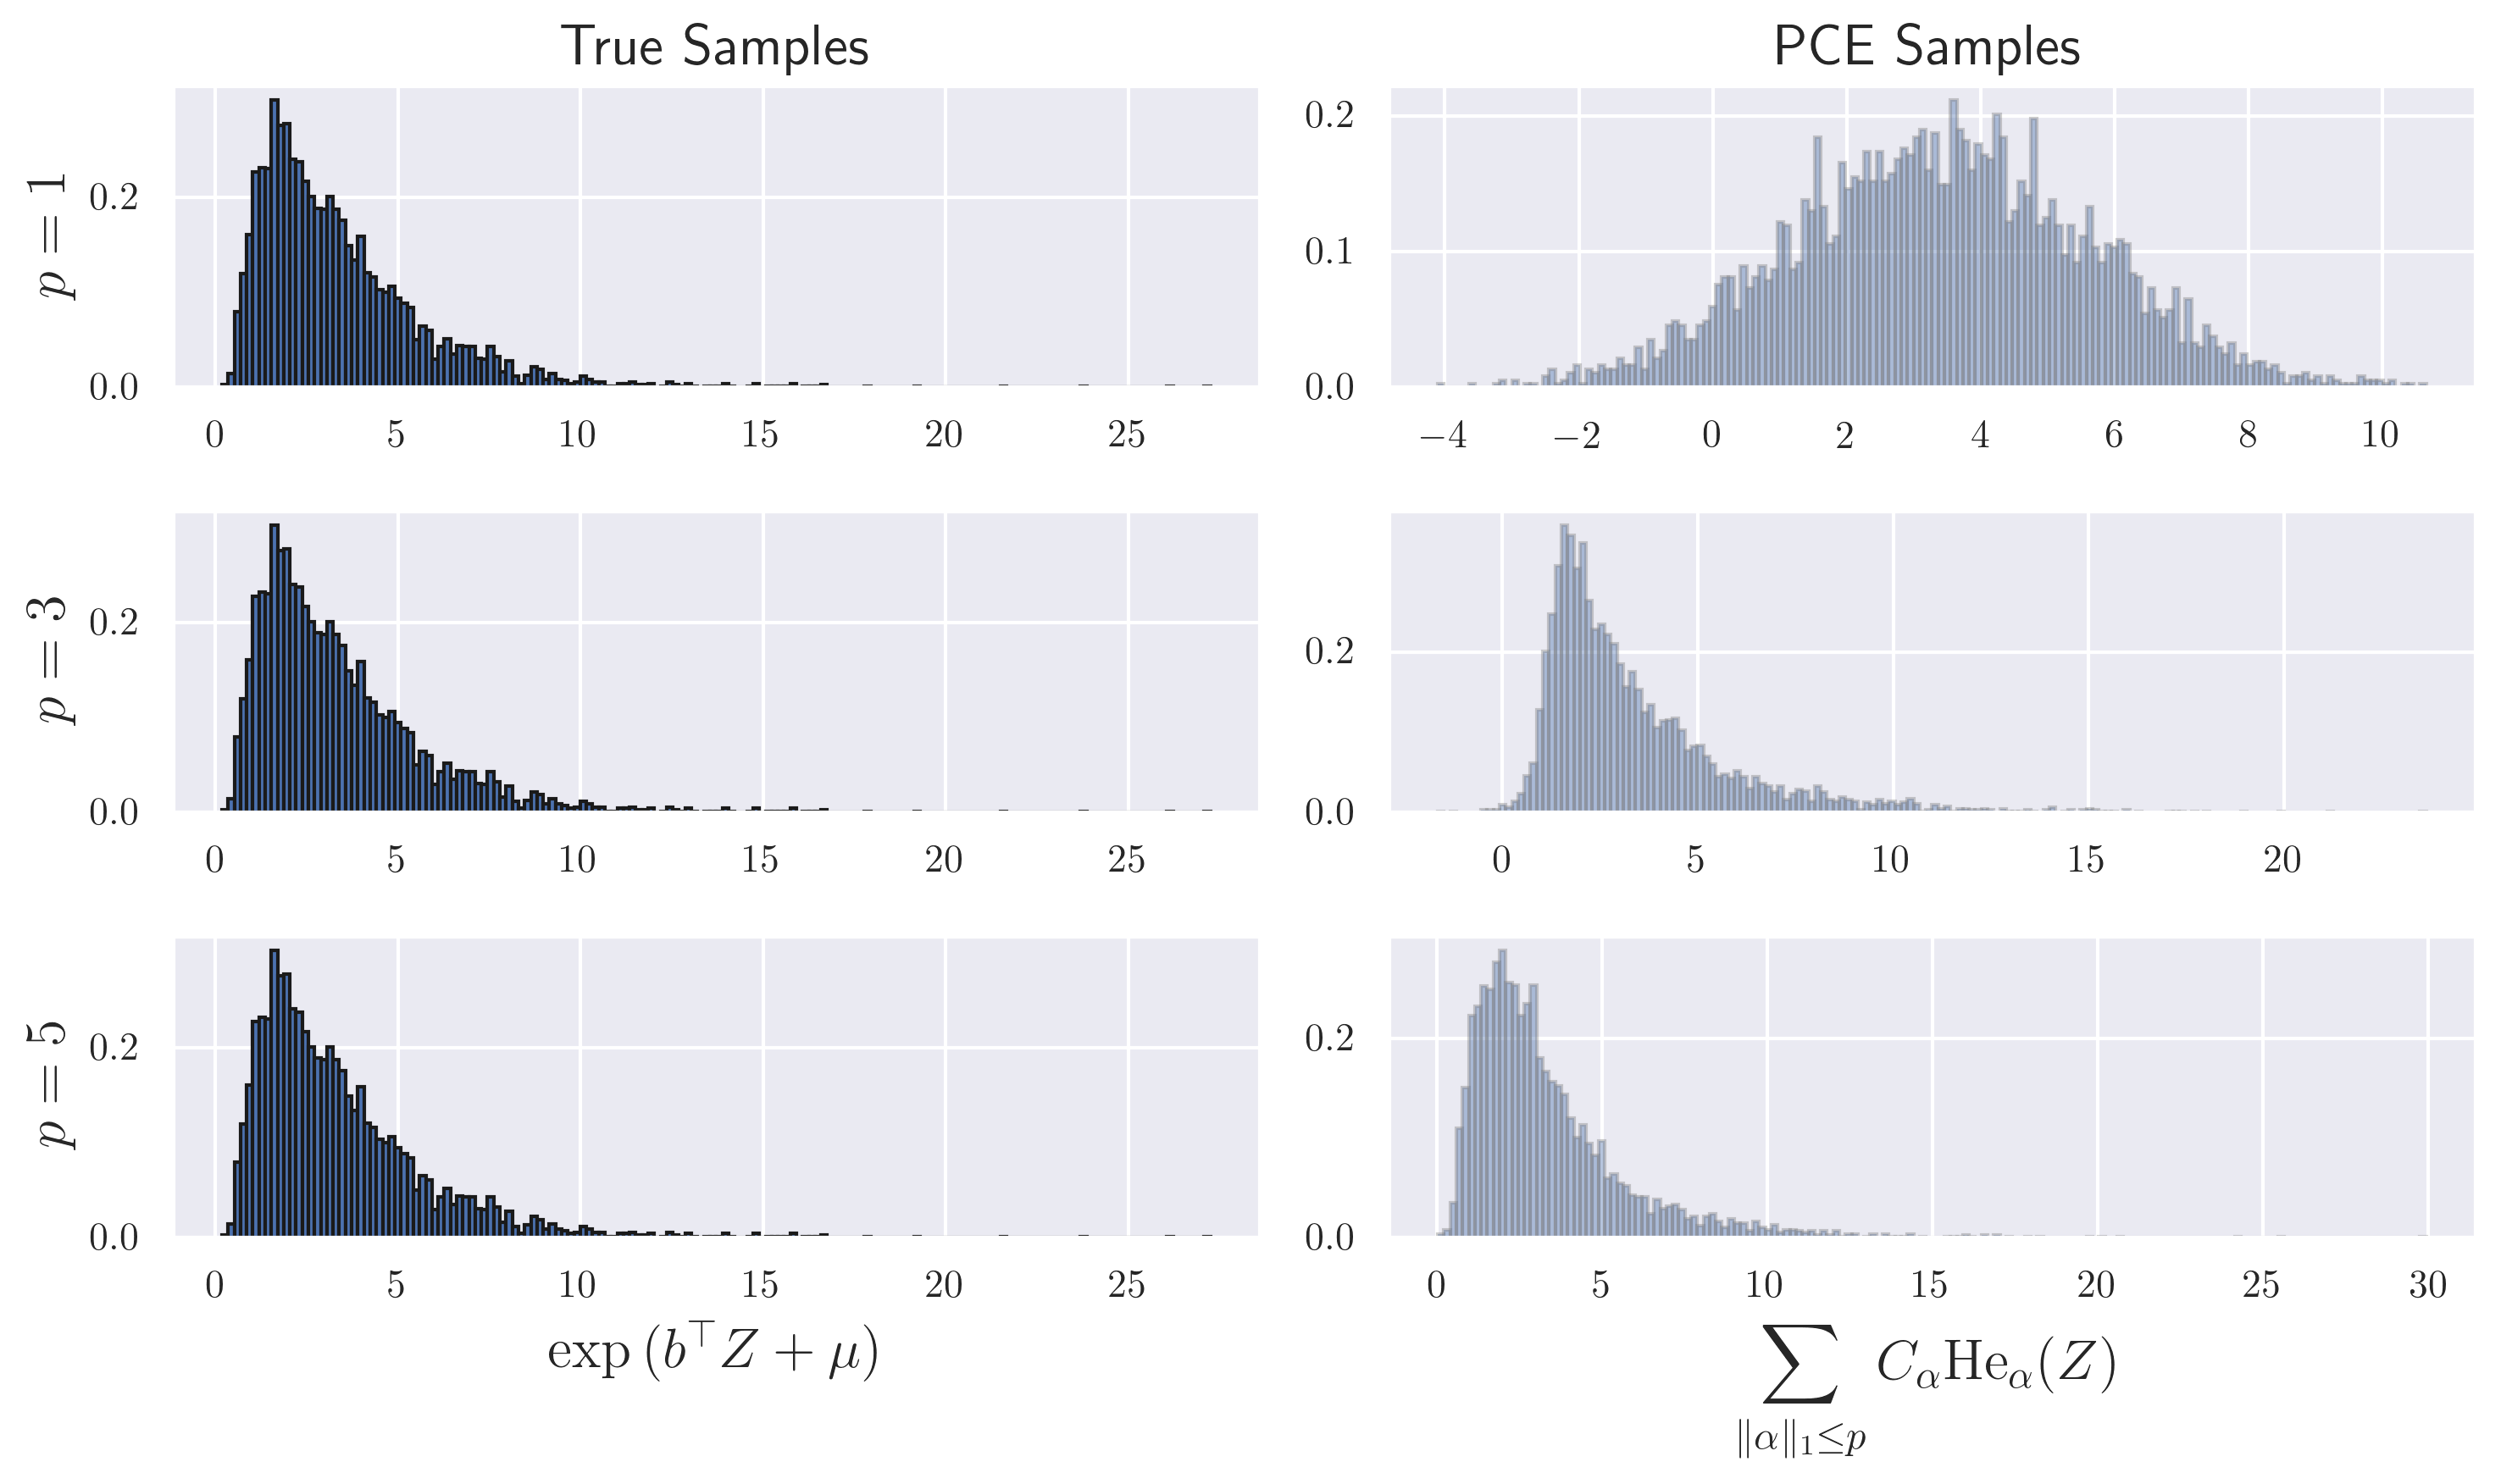

In [11]:
np.random.seed(1)
s = 4000
plist = [1,3,5]
true_samples = sample_true(s)

fig, ax = plt.subplots(len(plist),2,figsize=(10,6), dpi=300)
for i,p in enumerate(plist):
    pce_samples = sample_pce(p,s)
    
    # histogram
    nbins = 160

    ax[i,0].hist(true_samples, bins=nbins, ec='k', density=True)
    ax[i,1].hist(pce_samples, bins=nbins, alpha=0.4, ec='gray', density=True)
    ax[i,0].set_ylabel(fr"$p = {p}$", fontsize=16)

ax[0,0].set_title(f"True Samples", fontsize=16)
ax[0,1].set_title(f"PCE Samples", fontsize=16)
ax[-1,0].set_xlabel(r"$\exp{(b^\top Z + \mu)}$", fontsize=16)
ax[-1,1].set_xlabel(r"$$\sum_{\|\alpha\|_1 \leq p} C_{\alpha} \mathrm{He}_{\alpha}(Z)$$",
                    fontsize=16)
plt.tight_layout()

<!-- ## 1.(f) Closed-Form PCE of the Stochastic Process of Interest -->
After the previous derivations and implementations, we construct a polynomial representation of the stochastic process $k(x, \omega)=\exp (Y(x, \omega))$. 

Given the first $n$ K-L eigenfunctions and eigenvalues $\left(\phi_i(x), \lambda_i\right)_{i=1}^n$ of $Y$, we will write a closed form expression for this polynomial representation of the form
$$
k^n(x, \omega)=\sum_{\alpha \in \mathbb{N}_0^n} c_{\boldsymbol{\alpha}}(x) \Psi_\alpha\left(Z_1(\omega), \ldots, Z_n(\omega)\right)
$$

Note that this representation will already incur the error of truncating the K-L expansion of $Y$ at $n$ terms.

Let the $n$-term K-L expansion of $Y(x, \omega)$ be
$$
Y^n(x, \omega) = \mu(x) + \sum^n_{i=1}\sqrt{\lambda_i}\psi_i(x)Z_i(\omega),
$$
where $\psi_i(x)$ are the eigenfunctions, and $\left(Z_1, \ldots, Z_n\right) \sim \mathcal{N}\left(0, I_n\right)$ due to Gaussian-ity. This can be viewed as 
$$
Y^n(x, \omega) = b^{\top} Z+\mu
$$
where $\mu = \mu(x)$, $Z =  \left(Z_1, \ldots, Z_n\right)$, and $b_i = \sqrt{\lambda_i}\psi_i(x)$. As such, by the formula derived in 1.(d), we have

\begin{align*}
  k^n(x, \omega) = \exp(Y^n(x, \omega)) = \exp\left(\mu(x) + \sum^n_{i=1}\sqrt{\lambda_i}\psi_i(x)Z_i(\omega)\right) = \sum_{{\boldsymbol{\alpha}}\geq \overrightarrow{0}}^{\infty} C_{\boldsymbol{\alpha}}(x) \mathrm{He}_{\boldsymbol{\alpha}}(Z),
\end{align*}
where
\begin{align*}
C_{\boldsymbol{\alpha}}(x) = \exp\left(\mu(x) + \frac{1}{2}\sum^n_{i=1}\lambda_i\psi_i^2(x)\right)\prod^n_{i=1}\frac{\left(\sqrt{\lambda_i}\psi_i(x)\right)^{\alpha_i}}{\alpha_i!}.
\end{align*}

For later reference, we let 
$$
k^{n,r}(x, \omega) = \exp(Y^{n,r}(x, \omega)) = \exp\left(\mu(x) + \sum^r_{i=1}\sqrt{\lambda_i}\psi_i(x)Z_i(\omega)\right);
$$
that is, $k^{n,r}(x, \omega) $ is the exponential of the $r$-term truncated $n$-term K-L expansion of $Y(x,w)$. We let
$$
k^{n,r}_p(x, \omega) =  \sum_{{\|\boldsymbol{\alpha}}\|_1\leq p} C^{\,n,r}_{\boldsymbol{\alpha}}(x) \mathrm{He}_{\boldsymbol{\alpha}}(Z),
$$
where 
$$
C^{\,n,r}_{\boldsymbol{\alpha}}(x) = \exp\left(\mu(x) + \frac{1}{2}\sum^r_{i=1}\lambda_i\psi_i^2(x)\right)\prod^r_{i=1}\frac{\left(\sqrt{\lambda_i}\psi_i(x)\right)^{\alpha_i}}{\alpha_i!}.
$$
That is, $k^{n,r}_p(x, \omega)$ is the PCE, with threshold $p$, of $\exp(Y^{n,r}(x, \omega))$. We let 
$$
k^{n,p}(x, \omega) =  \sum_{{\|\boldsymbol{\alpha}}\|_1\leq p} C^{\,n}_{\boldsymbol{\alpha}}(x) \mathrm{He}_{\boldsymbol{\alpha}}(Z),
$$
where 
$$
C^{\,n}_{\boldsymbol{\alpha}}(x) = \exp\left(\mu(x) + \frac{1}{2}\sum^n_{i=1}\lambda_i\psi_i^2(x)\right)\prod^n_{i=1}\frac{\left(\sqrt{\lambda_i}\psi_i(x)\right)^{\alpha_i}}{\alpha_i!};
$$
that is, $k^{n,r}_p(x, \omega)$ is the PCE, with threshold $p$, of $\exp(Y^{n}(x, \omega))$.
<!-- ## 1.(g) -->

We now consider a grid of spatial locations $\left\{x_j\right\}_{j=1}^q \in \mathcal{D}$ and build a Hermite approximation of the random variable $k\left(x_j, \omega\right)$ at each of these points. 
For stochastic dimension $n$ and total degree $p$, we call the approximation $k^{n, p}\left(x_j, \omega\right)$. In this experiment, we will compute and compare $\operatorname{Var}\left[k^{n, p}\left(x_j, \omega\right)\right]$ and $k^{n, p}\left(x_j, \omega\right)$ at each $x_j$.

The PCE-driven sampling is implemented below.

In [125]:
def multi_herm_val(x, alpha):
    """ 
    Evaluate multi-variate hermite polynomial

    Input:
        x : points to evaluate, (s,n)
            s : number of points
            n : dimension of points
        
        alpha : degree index, (n,)
    
    Output: (s,)
    """
    s, n = x.shape
    res = np.ones((s,))
    for i,deg in enumerate(alpha):
        xi = x[:,i]
        all_deg_eval = hermitePoly(xi, deg) # (deg+1, s)
        herm_i = all_deg_eval[deg,:]
        res *= herm_i

    return res 

def c_alpha_x(alpha, 
              psi, 
              eigval,
              mu=1.0):
    """ 
    Closed-form formula of hermite coefficient

    Input:
        alpha: multi-index, (n,)
    """
    afact = np.prod(factorial(alpha))

    b = psi * np.sqrt(eigval).reshape(1,-1)
    bnorm = np.power(b,2)
    bnorm = np.sum(bnorm, axis=1) * 0.5

    result = np.exp(mu + bnorm) * np.prod(np.power(b, alpha), axis=1) / afact
    return result

def sample_pce_kl(n, r, s, p, xgrid):
    """ 
    Sample K(x,w) = exp(Y(x,w)) with polynomial chaos expansion combined with KL

    Input:
        n : number of total K-L modes
        r : dimension of KL truncation
        s : number of samples
        p : PCE maximum total degree

    """
    # spatial resolution
    N = xgrid.shape[0]

    # nystrom method for K-L Expansion
    _, eigval, _, eval_psi = nystrom(n)

    # evaluate eigenfunction on xgrid
    psi_full = eval_psi(xgrid)

    # truncate
    psi = psi_full[:,:r]
    eigval = eigval[:r]

    indices = totalOrderMultiIndices(r, p)
    z = np.random.randn(s,r)
    samples = np.zeros((N,s))
    for alpha in indices:
        samples += np.reshape(c_alpha_x(alpha, psi, eigval), (-1,1)) * \
                   np.reshape(multi_herm_val(z, alpha), (1,-1))
    return samples,z

In the following experiment, we let $n=100$ and use $s=100$ samples of $k^{n,p}(x, \omega)$ where $p$ ranges from 1 to 3. We plot the sample variance of $k^{n,p}(x, \omega)$ for different $p$, and plot the approximate PDF of $k^{n,p}(x=0.5, \omega)$ for different $p$ along with its true PDF, which is available since $k^{n,p}(x=0.5, \omega)$ is a log-normal random variable.

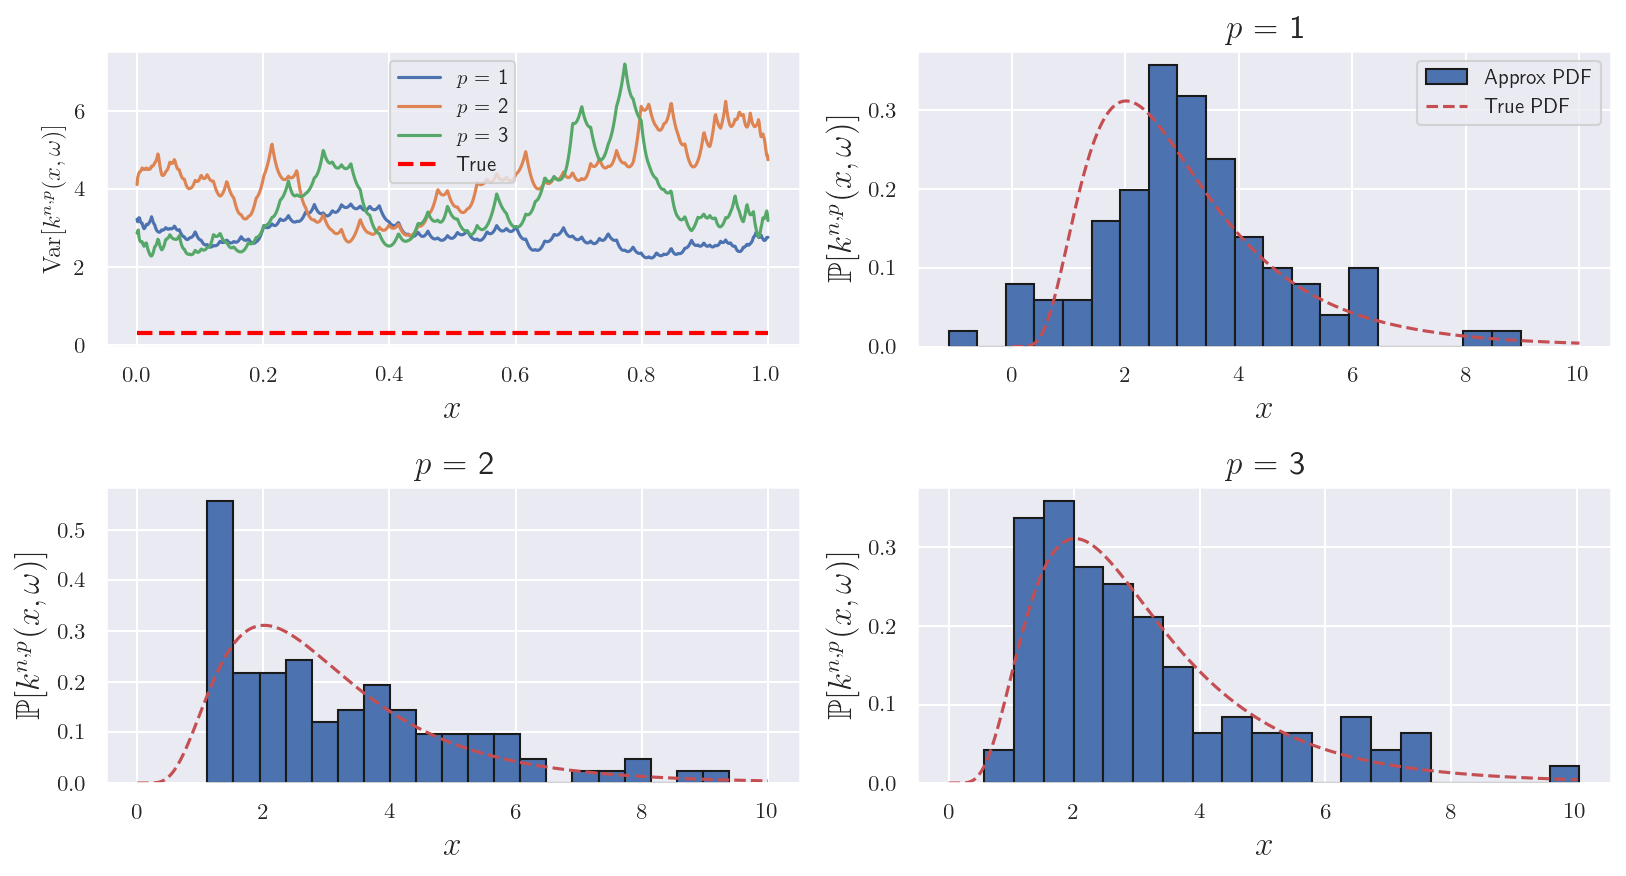

In [123]:
n = 100
r = n
s = 100
plist = np.asarray([
    1,2,3
])
xgrid = np.linspace(0,1,1001)
true_pdf = 1 / (np.sqrt(2*np.pi) * np.sqrt(0.3) * (np.linspace(0,10,10000)+1e-8)) * np.exp(- (np.log(np.linspace(0,10,10000)+1e-8) - 1)**2 / (2*0.3))

fig, ax = plt.subplots(2,2,figsize=(11,6),dpi=150)
np.random.seed(1)
for i,p in enumerate(plist):
    pcekl_samples,_ = sample_pce_kl(n,r,s,p,xgrid)
    pcekl_sample_var = np.var(pcekl_samples, axis=1)
    label = fr'$p$ = {p}'
    ax[0,0].plot(xgrid, pcekl_sample_var,label=label)

    I = (i+1)//2
    J = (i+1)%2
    u05_samples = pcekl_samples[500,:]

    nbins=20
    ax[I,J].hist(u05_samples,bins=nbins, ec='k', density=True, label="Approx PDF")
    ax[I,J].plot(np.linspace(0,10,10000), true_pdf, 'r--', label="True PDF")
    ax[I,J].set_title(label, fontsize=16)
    ax[I,J].set_xlabel(r"$x$",fontsize=16)
    ax[I,J].set_ylabel(r"$\mathbb{P}[k^{n,p}(x, \omega)]$",fontsize=16)

ax[0,0].hlines(y=0.3, xmin=0, xmax=1, colors='red', linestyles='--', lw=2, label="True")
ax[0,0].set_xlabel(r"$x$",fontsize=16)
ax[0,0].set_ylabel(r"$\mathrm{Var}[k^{n,p}(x, \omega)]$")
ax[0,0].legend(prop={'size': 10})
ax[0,1].legend(prop={'size': 10})
plt.tight_layout()

As $p$ gets bigger, the shape of the true PDF gets better captured. 

Next, we fix $p=2$ and select $n$ from $\{4,8,16,32,64\}$ and repeat the experiment. Here, we are only able to afford $s=100$ samples.

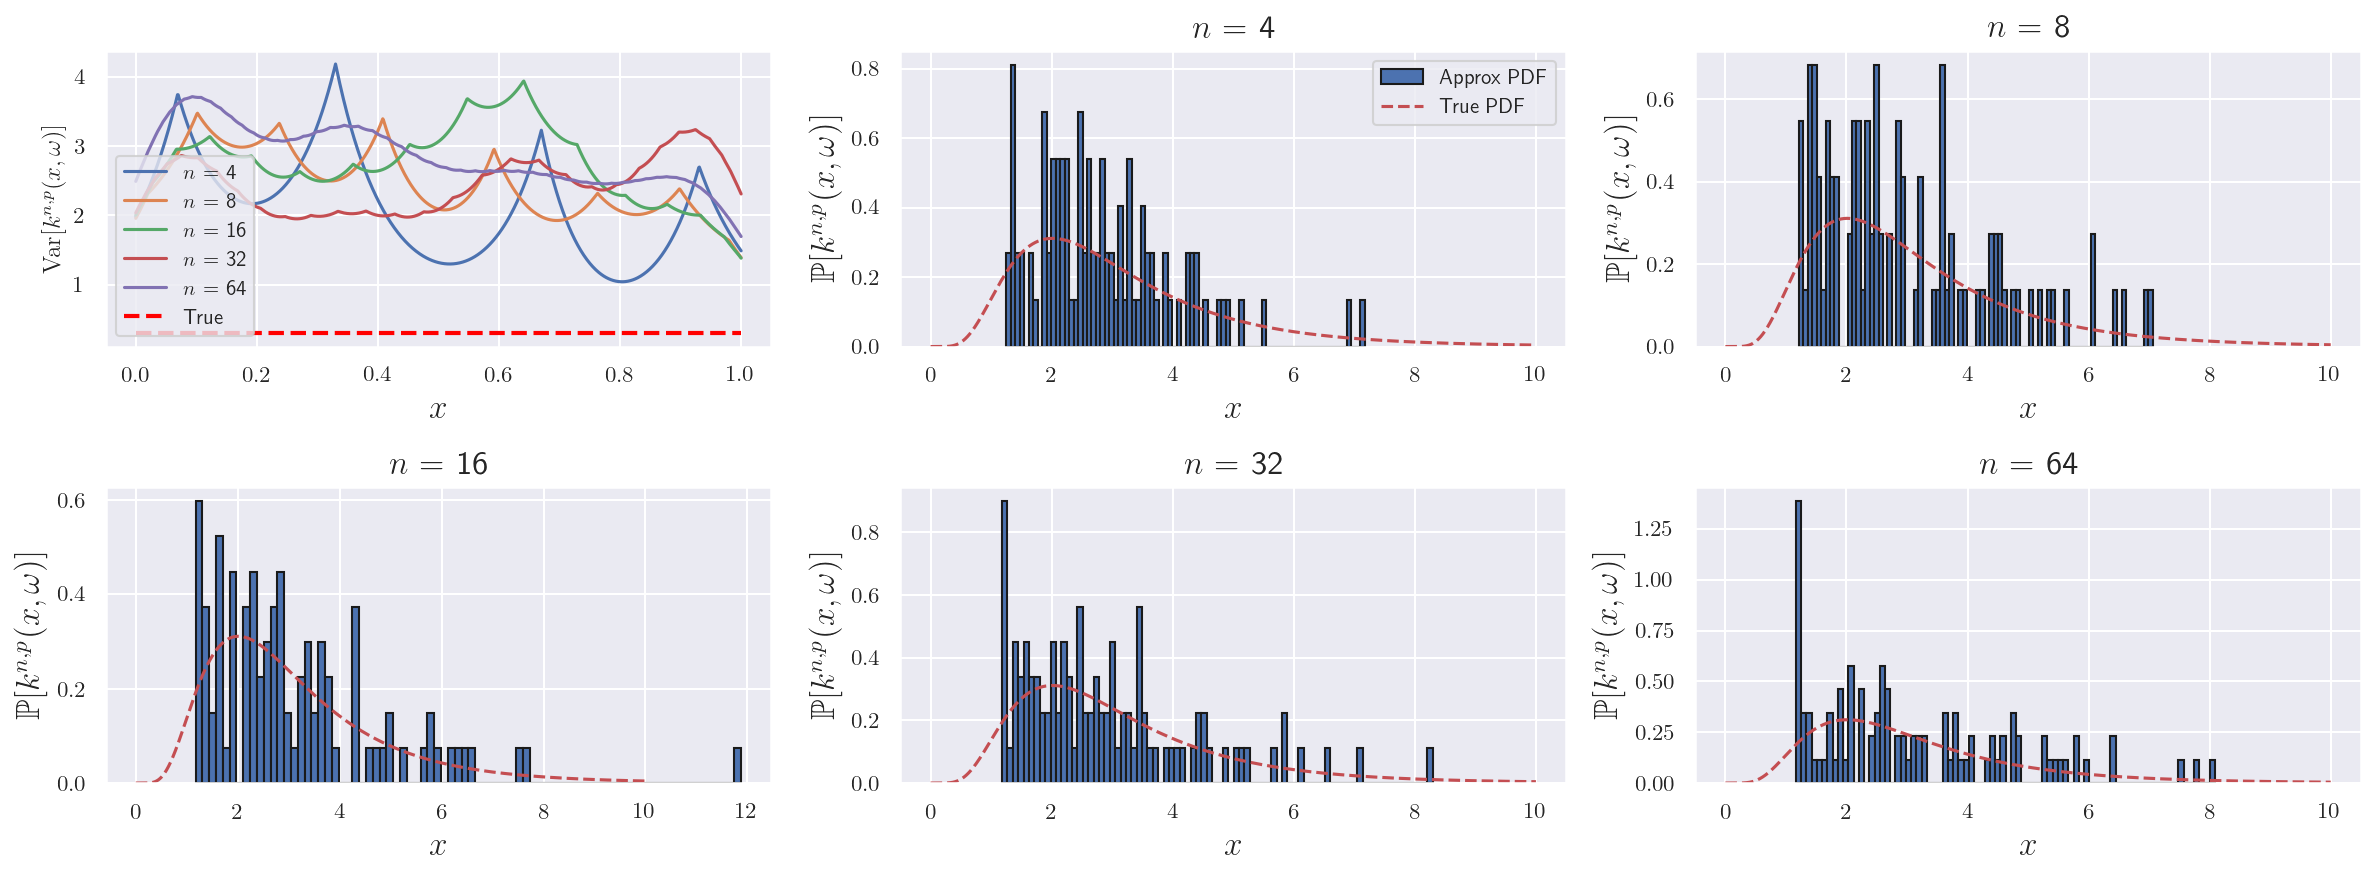

In [122]:
nlist = np.asarray([
    4,8,16,32,64
])
r = n
s = 100
p = 2
xgrid = np.linspace(0,1,1001)

true_pdf = 1 / (np.sqrt(2*np.pi) * np.sqrt(0.3) * (np.linspace(0,10,10000)+1e-8)) * np.exp(- (np.log(np.linspace(0,10,10000)+1e-8) - 1)**2 / (2*0.3))

fig, ax = plt.subplots(2,3,figsize=(16,6),dpi=150)
np.random.seed(1)
for i,n in enumerate(nlist):
    pcekl_samples,_ = sample_pce_kl(n,r,s,p,xgrid)
    pcekl_sample_var = np.var(pcekl_samples, axis=1)
    label = fr'$n$ = {n}'
    ax[0,0].plot(xgrid, pcekl_sample_var,label=label)

    I = (i+1)//3
    J = (i+1)%3
    u05_samples = pcekl_samples[500,:]

    nbins=80
    ax[I,J].hist(u05_samples,bins=nbins, ec='k', density=True, label="Approx PDF")
    ax[I,J].plot(np.linspace(0,10,10000), true_pdf, 'r--', label="True PDF")
    ax[I,J].set_title(label, fontsize=16)
    ax[I,J].set_xlabel(r"$x$",fontsize=16)
    ax[I,J].set_ylabel(r"$\mathbb{P}[k^{n,p}(x, \omega)]$",fontsize=16)

ax[0,0].hlines(y=0.3, xmin=0, xmax=1, colors='red', linestyles='--', lw=2, label="True")
ax[0,0].set_xlabel(r"$x$",fontsize=16)
ax[0,0].set_ylabel(r"$\mathrm{Var}[k^{n,p}(x, \omega)]$")
ax[0,0].legend(prop={'size': 10})
ax[0,1].legend(prop={'size': 10})
plt.tight_layout()

From the plot above, again we see that the general shape of the true PDF is better captured as $n$ gets bigger. But unfortunately the sample size is not big enough to well approximate the whole function.

## Solving a stochastic PDE: building blocks
Consider a stochastic elliptic equation on a one-dimensional spatial domain:

$$
\frac{\partial}{\partial x}\left(k(x, \omega) \frac{\partial u(x, \omega)}{\partial x}\right)=-s(x), \quad x \in \mathcal{D}=[0,1]
$$

with a deterministic source term $s(x)$, a deterministic Dirichlet boundary condition at $x=1$,

$$
u(1, \omega)=u_r
$$

and a random Neumann condition at $x=0$,

$$
\left.k(x, \omega) \frac{\partial u}{\partial x}\right|_{x=0}=-F(\omega)
$$


The diffusivity $k(x, \omega)$ and solution $u(x, \omega)$ are stochastic processes defined on $\mathcal{D} \times \Omega$, where $(\Omega, \mathcal{U}, \mathbb{P})$ is a probability space. $F(\omega)$ is defined on the same probability space. This stochastic elliptic equation can model a host of physical phenomena, ranging from heat conduction in a heterogeneous material (where $u$ is proportional to temperature) to fluid flow in a porous medium (where $u$ denotes pressure and $k$ is proportional to permeability).

Parameters and boundary conditions are specified as follows:
- Let $Y(x, \omega)$ be just as we defined it in Section 1: a stationary Gaussian process with covariance kernel

$$
C\left(x_1, x_2\right)=\sigma_Y^2 \exp \left(-\frac{1}{a}\left(\frac{\left|x_1-x_2\right|}{\ell}\right)^a\right)
$$

and mean $\mathbb{E}[Y(x, \omega)]=\mu_Y$. Then the diffusivity $k(x, \omega) \equiv \exp (Y(x, \omega))$. Use the following parameter values: mean $\mu_Y=1.0$, correlation length $\ell=0.3$, variance $\sigma_Y^2=0.3$, and exponent $a=1.0$
- The flux $F$ is normally distributed with mean $\mu_F=-1.0$ and variance $\sigma_F^2=0.2$. $F$ and $k$ are independent.
- The Dirichlet datum is $u_r=1$.
- The source term is spatially uniform: $s(x)=5$.

The solver of the stochastic differential equation (SDE) is implemented below.

In [126]:
def diffusioneqn(xgrid, F, k, source, rightbc):
    """
    Solve 1-D diffusion equation with given diffusivity field k
    and left-hand flux F.

    ARGUMENTS: 
        xgrid = vector with equidistant grid points
            F = flux at left-hand boundary, k*du/dx = -F 
    source = source term, either a vector of values at points in xgrid
                or a constant
    rightbc = Dirichlet BC on right-hand boundary
    Domain is given by xgrid (should be [0,1])
    """
    N = len(xgrid)
    h = xgrid[N-1] - xgrid[N-2]
    
    A = np.zeros((N-1, N-1))
    b = np.zeros(N-1)
    
    if isinstance(source, (int, float)):
        f = -source * np.ones(N-1)
    else:
        f = -source[:N-1]
    
    A -= np.diag(2*k[:-1] + k[1:] + np.insert(k[:-2],0,k[0]))
    A += np.diag(  k[:-2] + k[1:-1], 1)
    A += np.diag(  k[:-2] + k[1:-1],-1)
    A /= 2 * h**2
    
    A[0, 1] += k[0] / h**2
    b[0] = 2 * F / h
    
    b[N-2] = rightbc * (k[N-1] + k[N-2]) / (2 * h**2)
    
    uinternal = np.linalg.solve(A, f - b)
    usolution = np.append(uinternal, rightbc)
    
    return usolution

In [127]:
from numpy.random import normal 
sx = 5 
rbc = 1

def draw_diff(n,s,xgrid,option,r):
    """ 
    Input:
        n : number of total K-L modes
        s : number of samples
        xgrid : grid to evaluate the process on
        option : different ways to sample the process
            'KL' : use K-L expansion with n terms
            'tKL' : use truncated K-L with r terms
            'PCE' : use polynomial chaos expansion with XX polynomial terms
        r: number of truncated K-L modes
    return : 
        K : (N,s) - s independent diffusivity function evaluated at xgrid
        Y : (N,s) - s independent samples of GP
    """
    if option=='KL': # urcated KL
        Y = sample_kl(n,s,xgrid) # (N,s), N: number of nodes
        K = np.exp(Y)
    elif option=='tKL': # truncated KL
        assert r > 0
        Y = sample_kl(n,s,xgrid,r)
        K = np.exp(Y)

    return K

def draw_flux(s):
    return normal(-1, np.sqrt(.2), size=s)

def sde_mc(n, s, xgrid=np.linspace(0,1,1001),option='KL',r=None):
    """ 
    MC simulation of sde

    input:
        n : number of K-L modes 
        s : number of samples
        xgrid : (N,) grid for solving sde
        option : select representations of the process

    output: 
        U : (N,s) simulation result
    """
    # grid size
    N = xgrid.shape[0] 

    # save results
    U = np.zeros((N,s)) 

    # draw parameters
    K = draw_diff(n,s,xgrid,option,r)
    F = draw_flux(s)

    # solve sde
    for i in range(s):
        k = K[:,i]
        f = F[i]
        u = diffusioneqn(xgrid, f, k, sx, rbc)
        assert u.shape==(N,)
        U[:,i] = u

    return U 


We select $x$ among $\{0.2,0.4,0.6,0.8\}$ and plot a histogram corresponding to each of the point-wise solution samples at those spatial points. The result is presented below. 

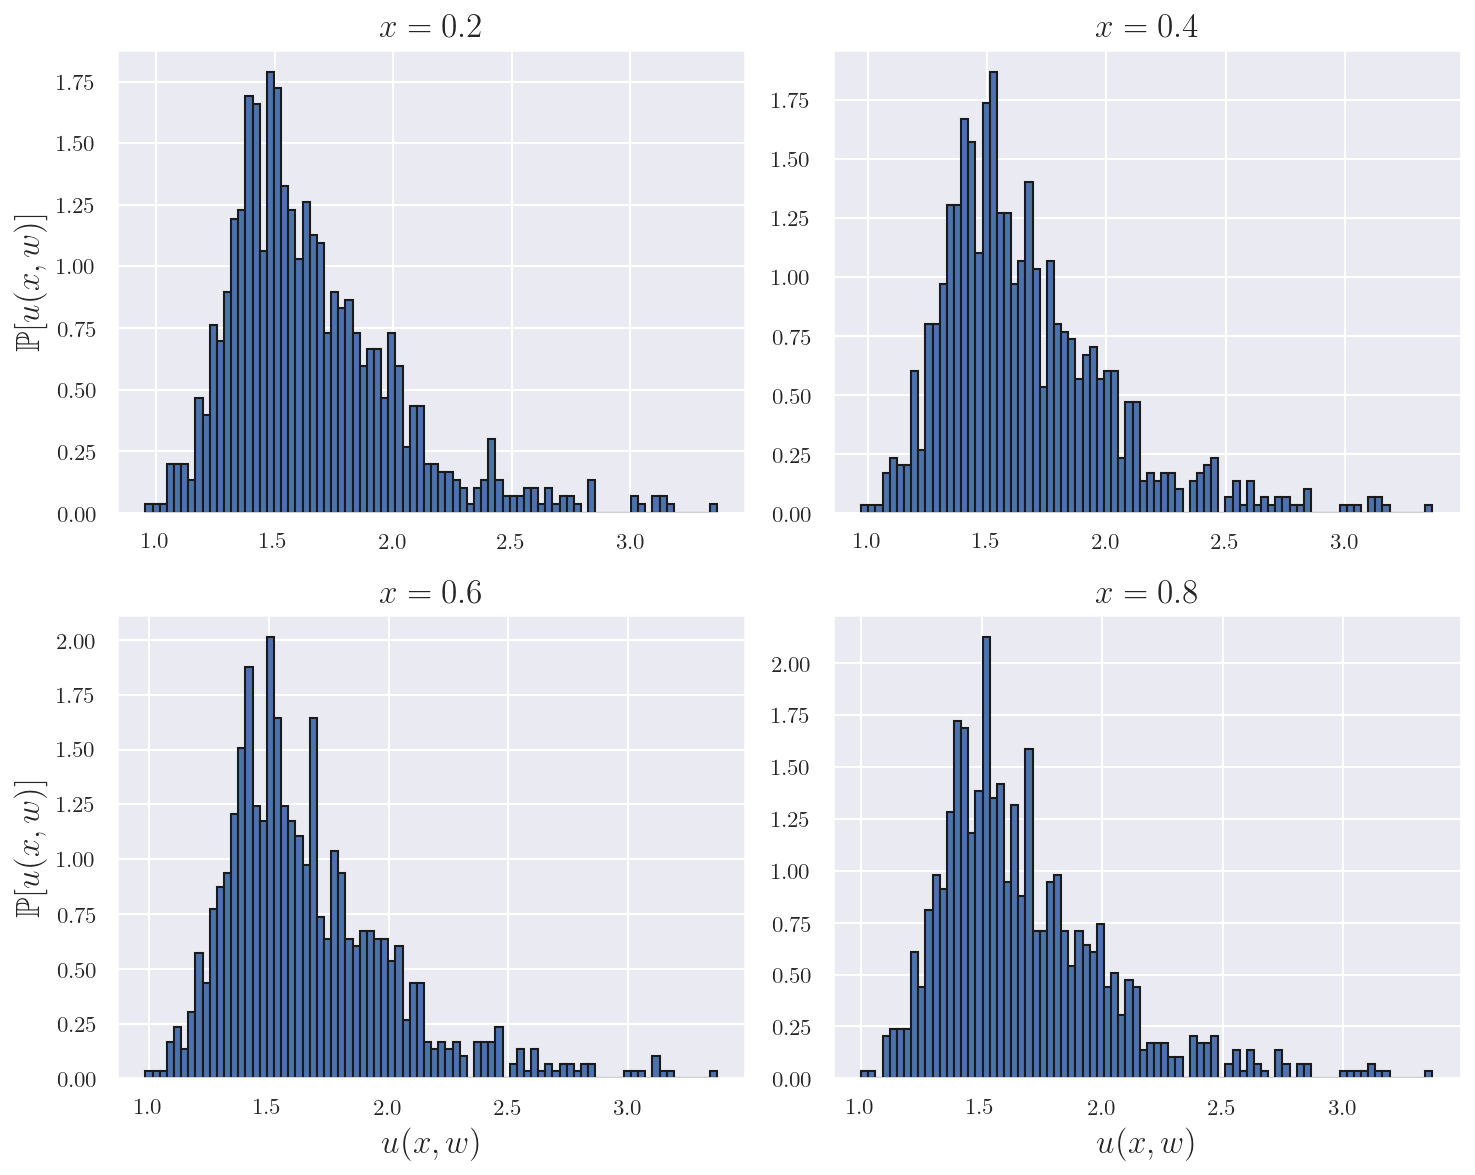

In [74]:
n = 1000 
s = 1000
xgrid = np.linspace(0,1,1001)

# Monte Carlo simulation
U = sde_mc(n,s,xgrid)

# x location
xlist = np.arange(0.2,0.81,0.2)

# plot density
fig, ax = plt.subplots(2,2, figsize = (10,8), dpi=150)
for i,x in enumerate(xlist):
    # get u(x,w)
    x = np.round(x,1)
    idx = int(100*x)
    ux = U[idx,:]

    # plot
    I = i//2
    J = i%2

    nbins = 80
    ax[I,J].hist(ux, bins=nbins, ec='k', density=True)
    ax[I,J].set_title(fr"$x = {x}$", fontsize=16)
    if I==1:
        ax[I,J].set_xlabel(r"$u(x,w)$", fontsize=16)
    if J==0:
        ax[I,J].set_ylabel(r"$\mathbb{P}[u(x,w)]$", fontsize=16)

plt.tight_layout()

From the result above, we see that when $x$ is small, the density of $u(x,w)$ is a bit more spreaded out than when $x$ is bigger. This can also be observed from the solution mean plot below.

Below, we plot the sample mean and covariance of the solution. The gray area corresponds to the 95% confidence interval, and so are all other gray areas reported in later part of the assignment. 

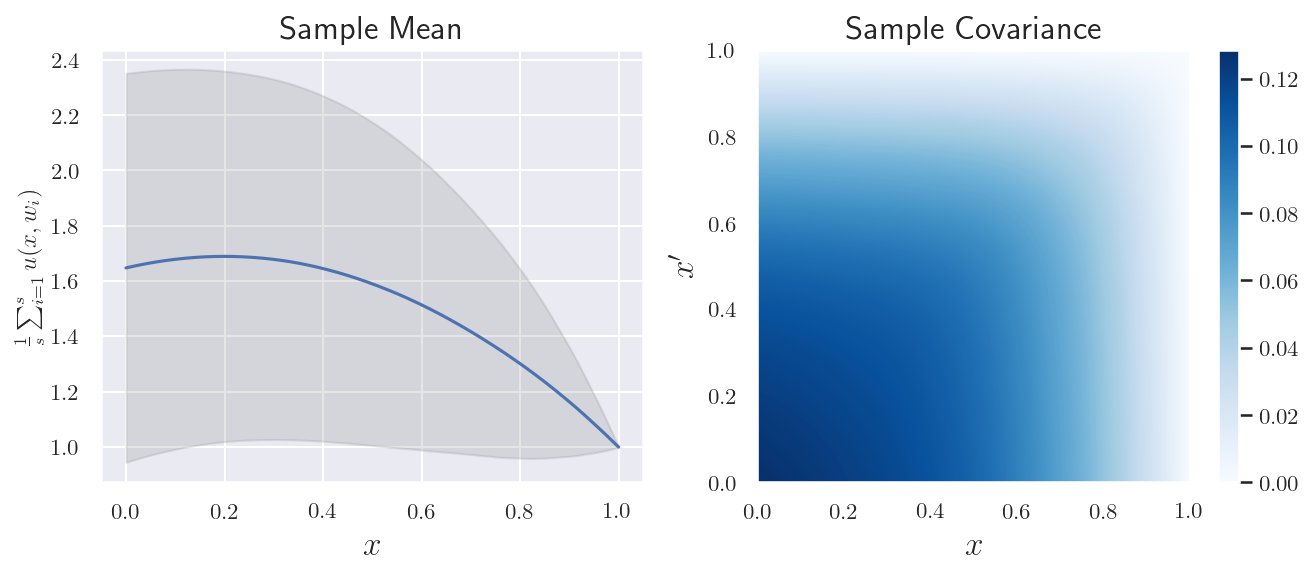

In [75]:
# sample mean and covariance
umean = np.mean(U,axis=1)
ustd = np.std(U, axis=1)
ucov = np.cov(U)

# plot  
fig, ax = plt.subplots(1,2, figsize = (9,4), dpi=150)

# mean
ax[0].plot(xgrid, umean)
ax[0].set_title(fr"Sample Mean", fontsize=16)
ax[0].set_xlabel(r"$x$", fontsize=16)
ax[0].set_ylabel(r"$\frac{1}{s}\sum_{i=1}^s u(x,w_i)$", fontsize=12)
ax[0].fill_between(xgrid, umean-1.96*ustd, umean+1.96*ustd, alpha=0.2, color="gray")

# covariacne
plt2 = ax[1].pcolormesh(xgrid, xgrid, ucov, cmap="Blues")
cbar = fig.colorbar(plt2)
ax[1].set_xlabel(r"$x$", fontsize=16)
ax[1].set_ylabel(r"$x^{\prime}$", fontsize=16)
ax[1].set_title("Sample Covariance", fontsize=16)
plt.tight_layout()

Next, we investigate the effect of using different representations of the diffusivity on the solution. In particular, we experiment with

1) $n$-term K-L expansion where $n$ is selected among $\{10,20,40,80,160,320\}$
2) $r$-term truncated $1000$-term K-L expansion where $r$ is selected among $\{10,20,40,80,160,320\}$
3) PCE of $5$-term truncated $1000$-term K-L expansion where the multi-index threshold $p$ is selected from $\{1,2,3,4,5\}$

#### 1. $n$-term K-L
We choose $n$ among $\{1,4,16,64,256\}$. For each $n$, we run $1000$ Monte Carlo simulations of the SDE, plot the sample mean of $u(x,w)$, and plot the 95% confidence region.

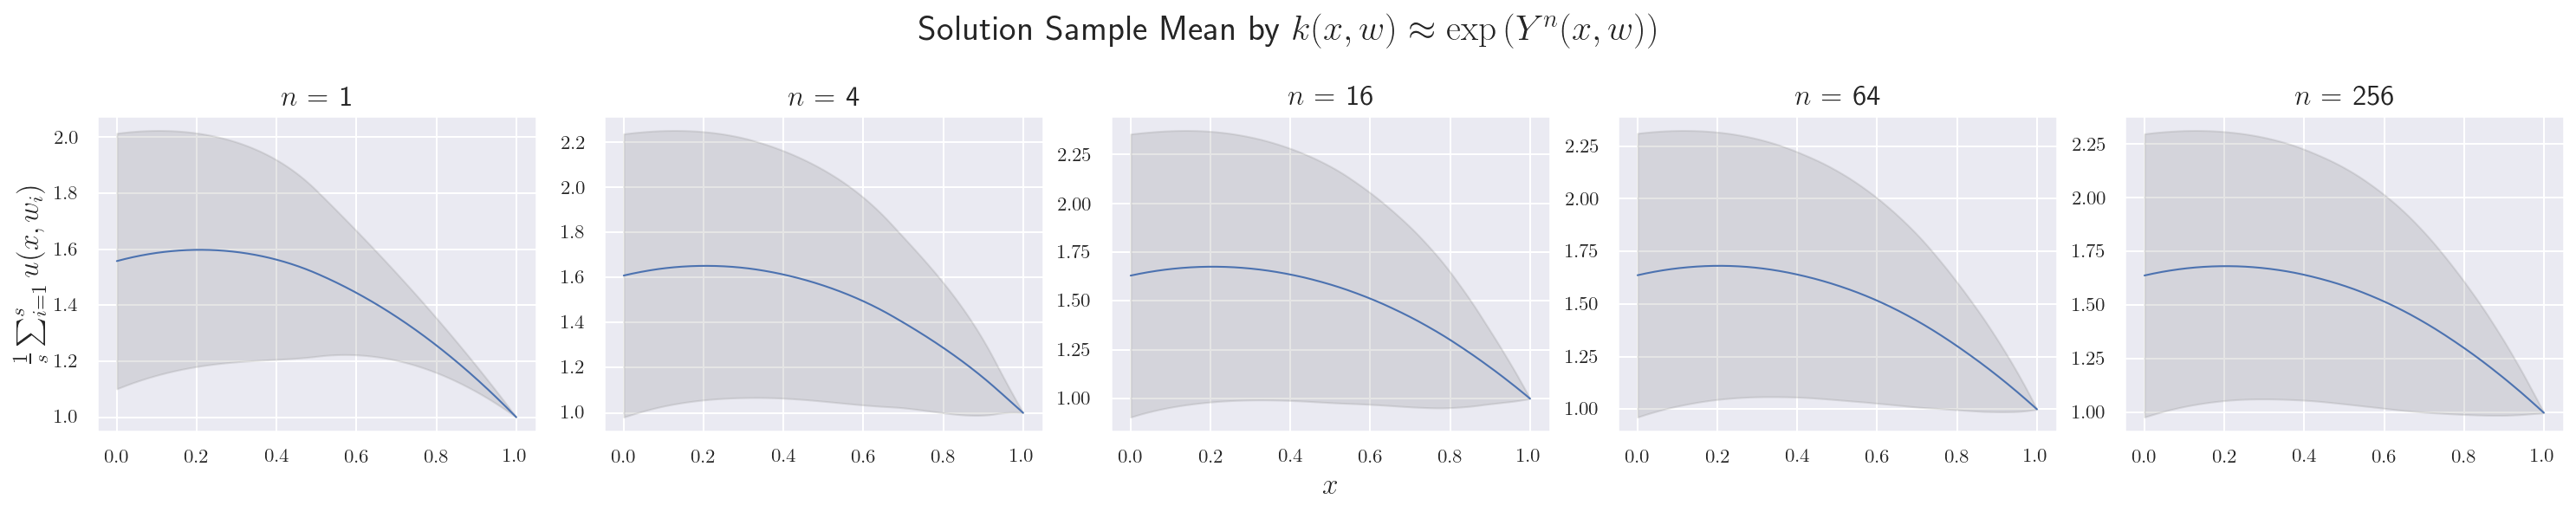

In [76]:
nlist = np.asarray([
    4**k for k in range(5)
]) 
s = 1000
xgrid = np.linspace(0,1,1001)

# Monte Carlo simulation
fig, ax = plt.subplots(1, nlist.shape[0], figsize=(4*nlist.shape[0],4), dpi=150)
for i,n in enumerate(nlist):
    U = sde_mc(n,s,xgrid)
    umean = np.mean(U,axis=1)
    ustd = np.std(U, axis=1)

    title = fr'$n$ = {n}'
    ax[i].set_title(title, fontsize=16)
    ax[i].plot(xgrid,umean,linewidth=1)
    ax[i].fill_between(xgrid, umean-1.96*ustd, umean+1.96*ustd, alpha=0.2, color="gray")

plt.suptitle(r"Solution Sample Mean by $k(x,w) \approx \exp{(Y^n(x,w))}$", fontsize=20)
ax[2].set_xlabel(r"$x$", fontsize=16)
ax[0].set_ylabel(r"$\frac{1}{s}\sum_{i=1}^s u(x,w_i)$", fontsize=16)
plt.tight_layout()

#### 2. $r$-term truncated $1000$-term K-L
We choose $r$ among $\{1,4,16,64,256\}$. For each $r$, we run $100$ Monte Carlo simulations of the SDE and plot the sample mean of $u(x,w)$.

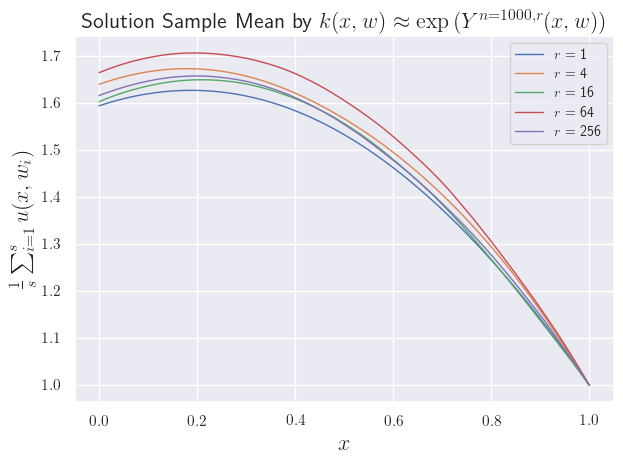

In [77]:
n = 1000 
s = 100
xgrid = np.linspace(0,1,1001)
rlist = np.asarray([
    4**k for k in range(5)
]) 
option = 'tKL'

# Monte Carlo simulation
for i,r in enumerate(rlist):
    U = sde_mc(n,s,xgrid,option,r)
    umean = np.mean(U,axis=1)

    label = fr'$r$ = {r}'
    plt.plot(xgrid,umean,linewidth=1,label=label)

plt.title(r"Solution Sample Mean by $k(x,w) \approx \exp{(Y^{n=1000,r}(x,w))}$", fontsize=16)
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$\frac{1}{s}\sum_{i=1}^s u(x,w_i)$", fontsize=16)
plt.legend(prop={'size': 10})
plt.tight_layout()

#### 3. PCE Combined with K-L (PCE-KL)

In [128]:
def multi_herm_val(x, alpha):
    """ 
    Evaluate multi-variate hermite polynomial

    Input:
        x : points to evaluate, (s,n)
            s : number of points
            n : dimension of points
        
        alpha : degree index, (n,)
    
    Output: (s,)
    """
    s, n = x.shape
    res = np.ones((s,))
    for i,deg in enumerate(alpha):
        xi = x[:,i]
        all_deg_eval = hermitePoly(xi, deg) # (deg+1, s)
        herm_i = all_deg_eval[deg,:]
        res *= herm_i

    return res 

def c_alpha_x(alpha, 
              psi, 
              eigval,
              mu=1.0):
    """ 
    Closed-form formula of hermite coefficient

    Input:
        alpha: multi-index, (n,)
    """
    afact = np.prod(factorial(alpha))

    b = psi * np.sqrt(eigval).reshape(1,-1)
    bnorm = np.power(b,2)
    bnorm = np.sum(bnorm, axis=1) * 0.5

    result = np.exp(mu + bnorm) * np.prod(np.power(b, alpha), axis=1) / afact
    return result

def sample_pce_kl(n, r, s, p, xgrid):
    """ 
    Sample K(x,w) = exp(Y(x,w)) with polynomial chaos expansion combined with KL

    Input:
        n : number of total K-L modes
        r : dimension of KL truncation
        s : number of samples
        p : PCE maximum total degree

    """
    # spatial resolution
    N = xgrid.shape[0]

    # nystrom method for K-L Expansion
    _, eigval, _, eval_psi = nystrom(n)

    # evaluate eigenfunction on xgrid
    psi_full = eval_psi(xgrid)

    # truncate
    psi = psi_full[:,:r]
    eigval = eigval[:r]

    indices = totalOrderMultiIndices(r, p)
    z = np.random.randn(s,r)
    samples = np.zeros((N,s))
    for alpha in indices:
        samples += np.reshape(c_alpha_x(alpha, psi, eigval), (-1,1)) * \
                   np.reshape(multi_herm_val(z, alpha), (1,-1))
    return samples, z

The Monte Carlo simulation of the SDE is re-implemented below to adapt to the PCE-KL representation of the diffusivity.

In [129]:
sx = 5 
rbc = 1

def draw_diff(n,s,xgrid,option='KL',r=None,p=None):
    """ 
    Input:
        n : number of total K-L modes
        s : number of samples
        xgrid : grid to evaluate the process on
        option : different ways to sample the process
            'KL' : use K-L expansion with n terms
            'tKL' : use truncated K-L with r terms
            'PCE' : use polynomial chaos expansion with XX polynomial terms
        r: number of truncated K-L modes
        p: PCE multi-index threshold
    return : 
        K : (N,s) - s independent diffusivity function evaluated at xgrid
        Y : (N,s) - s independent samples of GP
    """
    if option=='KL': # urcated KL
        Y = sample_kl(n,s,xgrid) # (N,s), N: number of nodes
        K = np.exp(Y)
    elif option=='tKL': # truncated KL
        assert r > 0
        Y = sample_kl(n,s,xgrid,r)
        K = np.exp(Y)
    elif option=='PCE': # polynomial chaos expansion
        assert r > 0
        assert p > 0
        K,_ = sample_pce_kl(n, r, s, p, xgrid)

    return K

def sde_mc(n, s, xgrid=np.linspace(0,1,1001),option='KL',r=None,p=None,KF=None):
    """ 
    MC simulation of sde

    input:
        n : number of K-L modes 
        s : number of samples
        xgrid : (N,) grid for solving sde
        option : select representations of the process
        r : KL truncation
        p : PCE multi-index threshold

    output: 
        U : (N,s) simulation result
    """
    # grid size
    N = xgrid.shape[0] 

    # save results
    U = np.zeros((N,s)) 

    # draw parameters
    if KF is not None:
        K = KF[:, :-1]
        K = K.T
        F = KF[:, -1]
    else:
        K = draw_diff(n,s,xgrid,option,r,p)
        F = draw_flux(s)

    # solve sde
    for i in range(s):
        k = K[:,i]
        f = F[i]
        u = diffusioneqn(xgrid, f, k, sx, rbc)
        assert u.shape==(N,)
        U[:,i] = u

    return U 

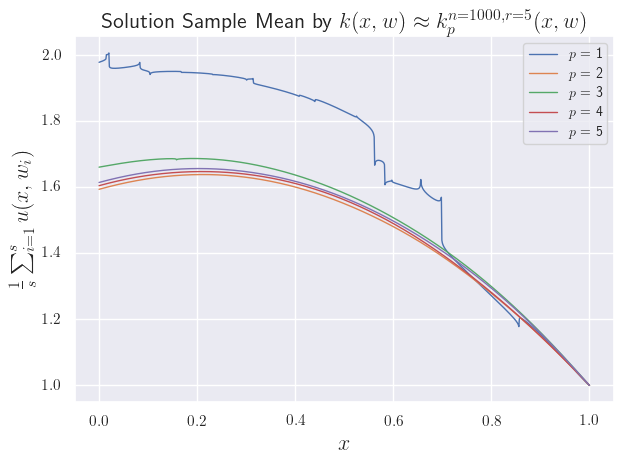

In [80]:
n = 1000
r = 5
s = 100
plist = np.asarray([
    1,2,3,4,5
])
xgrid = np.linspace(0,1,1001)
option = 'PCE'

np.random.seed(1)
for i,p in enumerate(plist):
    U = sde_mc(n,s,xgrid,option,r,p)
    umean = np.mean(U,axis=1)

    label = fr'$p$ = {p}'
    plt.plot(xgrid,umean,linewidth=1,label=label)

plt.title(r"Solution Sample Mean by $k(x,w) \approx k^{n=1000,r=5}_p(x,w)$", fontsize=16)
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$\frac{1}{s}\sum_{i=1}^s u(x,w_i)$", fontsize=16)
plt.legend(prop={'size': 10})
plt.tight_layout()

From the result above, we see that when $p$ is very small (1 or 2 and especially 1), the solution mean is not smooth. In fact, even when $p=2$, the unsmoothness is only observed at around $x=0.17$ but not other places. 

<!-- ## 2.(b) Sensitivity Indices -->
Consider $u$ at $x=0.5$. We then implement Saltelli's Method to calculate main and total-effect global sensitivity indices for $u(x=0.5)$ with respect to the diffusivity $k$ and the flux $F$. This tells us which factor contributes more to the variance of the solution.

In [130]:
def draw_all(s, n, xgrid):
    """ 
    Draw samples of diffusivity and flux

    Input:
        s : number of samples
        n : number of total K-L modes
    """
    K = draw_diff(n,s,xgrid)
    K = K.T # (s,N)
    
    F = draw_flux(s) # (s,)
    F = F.reshape(-1,1) # (s,1)
    res = np.hstack((K,F)) # (s,N+1)

    return res

def saltelli(s,n,xgrid=np.linspace(0,1,1001)):
    A = draw_all(s, n, xgrid)
    B = draw_all(s, n, xgrid)
    C_flux = A.copy()
    C_flux[:,-1] = B[:,-1]
    C_diff = A.copy()
    C_diff[:,:-1] = B[:,:-1]

    # compute solutions
    U_A = sde_mc(n,s,xgrid,KF=A)
    UA05 = U_A[500,:]
    U_B = sde_mc(n,s,xgrid,KF=B)
    UB05 = U_B[500,:]
    U_Cflux = sde_mc(n,s,xgrid,KF=C_flux)
    UCflux05 = U_Cflux[500,:]
    U_Cdiff = sde_mc(n,s,xgrid,KF=C_diff)
    UCdiff05 = U_Cdiff[500,:]

    f0sq = np.mean(UA05) **2
    S_diff_main = (np.mean(UA05 * UCflux05) - f0sq) / (np.mean(UA05 **2) - f0sq)
    S_diff_total = 1 - (np.mean(UB05 * UCflux05) - f0sq) / (np.mean(UA05 **2) - f0sq)
    S_flux_main = (np.mean(UA05 * UCdiff05) - f0sq) / (np.mean(UA05 **2) - f0sq)
    S_flux_total = 1 - (np.mean(UB05 * UCdiff05) - f0sq) / (np.mean(UA05 **2) - f0sq)
    
    return S_flux_main, S_flux_total, S_diff_main, S_diff_total


We use 10000 samples to compute the sensitivity indices.

In [97]:
s = 10000
n = 100

np.random.seed(4)
S_flux_main, S_flux_total, S_diff_main, S_diff_total = saltelli(s,n)

print("Flux Main Index:", S_flux_main)
print("Flux Total Index:", S_flux_total)
print("Diffusivity Main Index:", S_diff_main)
print("Diffusivity Total Index:", S_diff_total)

Flux Main Index: 0.1631757841545829
Flux Total Index: 0.12863841188294622
Diffusivity Main Index: 0.7978349231054208
Diffusivity Total Index: 0.9470272242105715


From the result, we see that the diffusivity is more influential to the solution of the SDE than the flux.

## Solving the Stochastic PDE

In the preceding parts of the notebook, we investigated the Karhunen-Loève representation of the log-diffusivity field $Y(x, \omega)$ and the polynomial chaos expansion of the diffusivity field $k(x, \omega)$. We also characterized the solution of the stochastic elliptic PDE using Monte Carlo and performed some global sensitivity analysis. We will now solve the same PDE using a least-squares polynomial approximation.

In the notation below, we will assume that the K-L expansion of $Y$ has been truncated after $d-1=n$ stochastic dimensions. Adding an additional stochastic dimension for the uncertain boundary condition, the problem will have a total of $d$ stochastic dimensions, corresponding to independent input random variables $\xi_1, \ldots, \xi_d$. Since $Y$ is a Gaussian field and the boundary condition is Gaussian, these input random variables can all be made standard Gaussian (i.e., $\xi_i \sim N(0,1)$ ).
We fix $x_* = 0.5$. 


We are interested in solving the problem 
$$
\underset{\mathbf{c} \in \mathbb{R}^N}{\operatorname{argmin}}\|\mathbf{V} \mathbf{c}-\mathbf{f}\|_2^2
$$
where 
$$
\mathbf{V}=\left[\begin{array}{ccc}
\mathrm{He}_{\boldsymbol{\alpha}_1}\left(Z^{(1)}\right) & \cdots & \mathrm{He}_{\boldsymbol{\alpha}_N}\left(Z^{(1)}\right) \\
\vdots & \ddots & \vdots \\
\mathrm{He}_{\boldsymbol{\alpha}_1}\left(Z^{(s)}\right) & \cdots & \mathrm{He}_{\boldsymbol{\alpha}_N}\left(Z^{(s)}\right)
\end{array}\right], \quad \mathbf{f}=\left[\begin{array}{c}
f\left(Z^{(1)}\right) \\
\vdots \\
f\left(Z^{(s)}\right)
\end{array}\right],
$$
$\mathrm{He}_{\boldsymbol{\alpha}_k}(Z^{(i)})$ is the multivariate Hermite polynomial with multi-index $\boldsymbol{\alpha}_k$ evaluated at $Z^{(i)}$, $f\left(Z^{(i)}\right)$ in this case is $u(x=0.5,w_i)$ where the solution is induced by the SDE defined by the sample $Z^{(i)}$, and $Z^{(i)}$ is an independent sample of $Z = (Z_1, Z_2, \ldots, Z_r)$ where $Z$ defines the $r-1$-term truncated $n$-term K-L expansion of the log-normal diffusivity $Y(x,w)$ and the flux. Here we choose $n=1000$ similar to before. After the least-squares problem is solved, the approximate (samples of) the quantity of interest is computed by $\mathbf{V}\mathbf{c}$. Note that the cardinality, $N$, of the index set depends on the multi-index threshold $p$, similar to the PCE case.

Below, we implement the construction of the Vandermonde matrix. 



In [83]:
def build_V(s,r,p,z):
    indices = totalOrderMultiIndices(r, p)
    n_poly = indices.shape[0]
    mat = np.zeros((s,n_poly))
    for i, alpha in enumerate(indices):
        herm_alpha_x = multi_herm_val(z, alpha)
        mat[:,i] = herm_alpha_x[:]
    
    return mat

def rhs(n,s,xgrid,r,xidx=500):
    U = sde_mc(n,s,xgrid,option='tKL', r=r)
    Utarget = U[xidx,:]
    return Utarget

Next, we investigate the effect of varying the maximal total degree of the multivariate orthogonal polynomials by selecting $p$ among $\{1,2,3,4,5\}$. $n=1000$ and $r=5$ in the K-L expansion and use $s=1000$ for the Monte Carlo simulation. We plot the approximate $u(0.5,w)$ and compare it with the true solution. Note that the true solution is constructed by using high-fidelity Monte Carlo simulation of the SDE with the diffusivity represented by a high-fidelity K-L expansion. Note that the random samples of $Z$ are not varied with $p$ in the experiment below. 

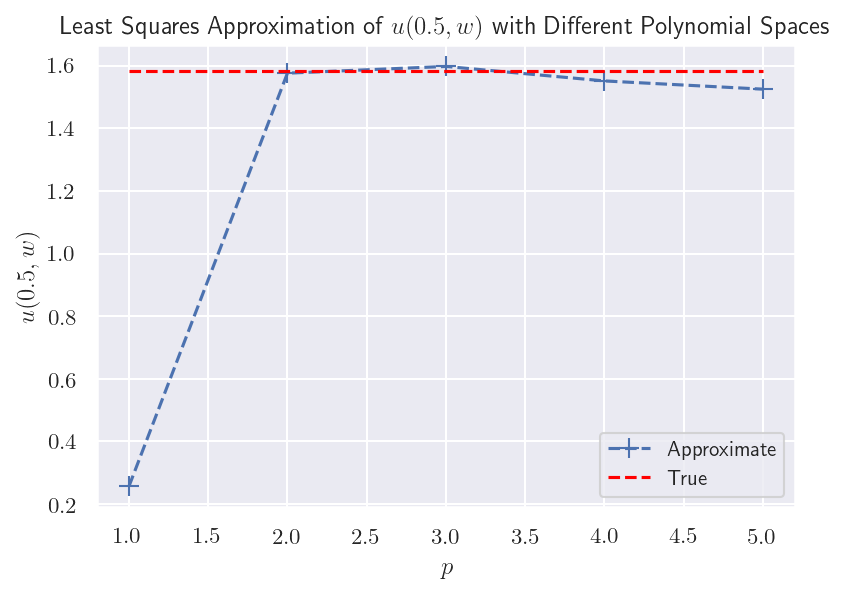

In [142]:
# params
np.random.seed(2)
n = 1000
s = 100
r = 5
plist = np.asarray([
    1,2,3,4,5
])
xgrid = np.linspace(0,1,1001)

# true
U = sde_mc(1000,1000,xgrid)
umean = np.mean(U,axis=1)
U05_true = umean[500]

plt.figure(figsize=(6,4),dpi=150)
U05_approx = []
for i,p in enumerate(plist):
    # truncated
    K, z = sample_pce_kl(n,r,s,p,xgrid)
    K = K.T
    flux = draw_flux(s).reshape(-1,1)
    KF = np.hstack((K,flux))
    z = np.hstack((z,flux))
    Ur = sde_mc(n,s,xgrid,KF=KF)

    # rhs
    f = Ur[500,:]

    # build LS problem
    V = build_V(s,r+1,p,z)
    
    # solve LS problem
    c = np.linalg.lstsq(V, f, rcond=None)[0]

    # approximate u(0.5,w)
    U05_approx.append(np.mean((V @ c.reshape(-1,1)).squeeze()))

plt.plot(plist, U05_approx, '--+', markersize=10, label="Approximate")
plt.hlines(U05_true, xmin=1, xmax=5, colors='red', linestyles='--', label='True')
plt.xlabel(r'$p$', fontsize=12)
plt.ylabel(r'$u(0.5,w)$', fontsize=12)
plt.title(r'Least Squares Approximation of $u(0.5,w)$ with Different Polynomial Spaces', fontsize=12)
plt.legend(prop={'size': 10})

From the result above, we see that increasing $p$ makes the approximation better. 

Below we investigate the effect of varying the number of Monte Carlo samples while keeping $p$ unchanged. We select $s$ among $\{2,4,8,16,32,64,128,256,512,1024,2048\}$.

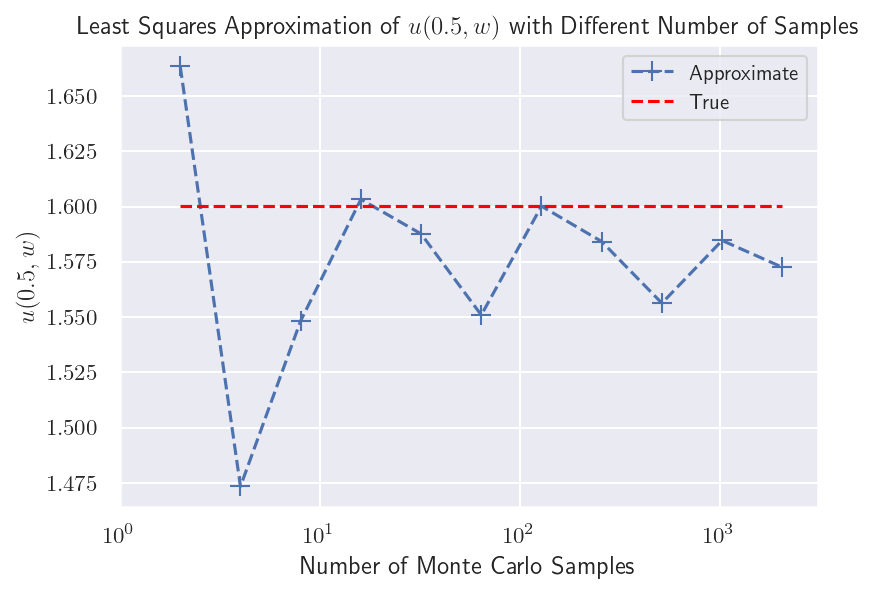

In [107]:
# Monte Carlo
# params
np.random.seed(1)
n = 1000
slist = np.asarray([
    2**(k+1) for k in range(11)
])
r = 5
p = 1
xgrid = np.linspace(0,1,1001)

# "True" u(0.5,w)
U = sde_mc(1000,1000,xgrid)
umean = np.mean(U,axis=1)
U05_true = umean[500]

plt.figure(figsize=(6,4),dpi=150)
U05_approx = []
for i,s in enumerate(slist):
    # truncated
    K, z = sample_pce_kl(n,r,s,p,xgrid)
    K = K.T
    flux = draw_flux(s).reshape(-1,1)
    KF = np.hstack((K,flux))
    z = np.hstack((z,flux))
    Ur = sde_mc(n,s,xgrid,KF=KF)
    f = Ur[500,:]

    # build LS problem
    
    V = build_V(s,r+1,p,z)

    # solve LS problem
    c = np.linalg.lstsq(V, f, rcond=None)[0]

    # approximate u(0.5,w)
    U05_approx.append(np.mean((V @ c.reshape(-1,1)).squeeze()))

plt.semilogx(slist, U05_approx, '--+', markersize=10, label="Approximate")
plt.hlines(U05_true, xmin=np.min(slist), xmax=np.max(slist), colors='red', linestyles='--', label='True')
plt.xlabel(r'Number of Monte Carlo Samples', fontsize=12)
plt.ylabel(r'$u(0.5,w)$', fontsize=12)
plt.xlim((np.min(slist)-1,np.max(slist)*1.5))
plt.title(r'Least Squares Approximation of $u(0.5,w)$ with Different Number of Samples', fontsize=12)
plt.legend(prop={'size': 10})

From the result above, we see that when there are only few Monte Carlo samples (fewer than 50), the approximate solution at $x=0.5$ is not stable and can deviate a lot. When there are more than 100 samples, the approximate solution is much more stable and does not deviate much.

In the last part, we used least-squares approximation to approximate $u(0.5,w)$. In this part, we hope to approximate $u(x,w)$ for all $x$. We do this by solving the least squares problem above with multiple different $\mathbf{f}$ where each of them corresponds to a different target of interest $u(x=x_i,w)$. After the least-squares problem is solved, the approximate solution samples are recovered accordingly.

Here, we use $s=1000$ samples to perform both the least-squares approximation of $u(x,w)$ and the sample average of $u(x,w)$ by representing the diffusivity and the flux as 1000-term K-L expansion. The grid is again uniform with a size of 1001. We plot the solution sample mean, covariance, and realizations of the least-squares approximation on the top and of the K-L on the bottom. 

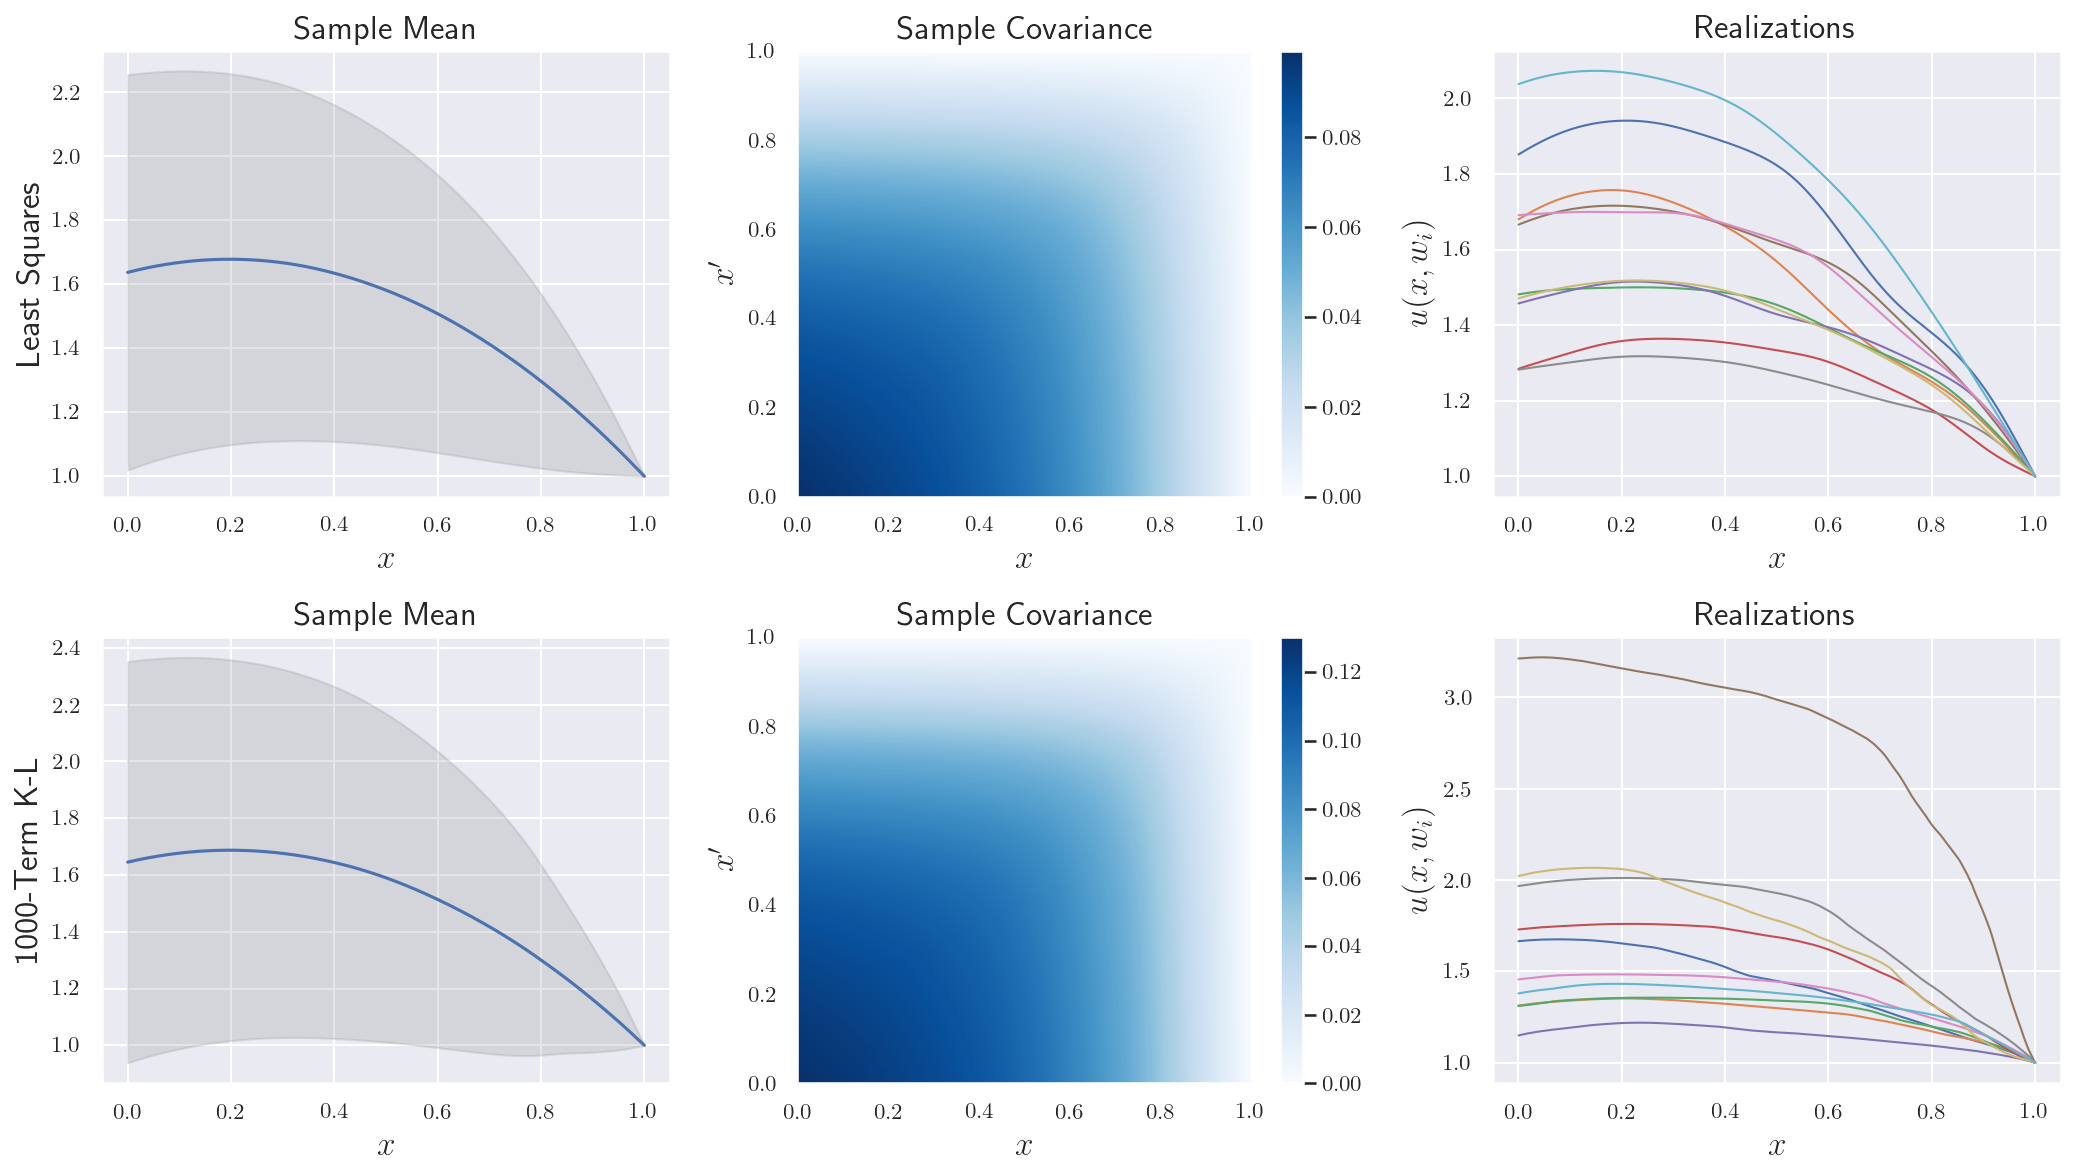

In [137]:
# Monte Carlo
# params
np.random.seed(1)
n = 1000
s = 1000
r = 10
p = 2
xgrid = np.linspace(0,1,1001)

# build Vandermonde matrix
K, z = sample_pce_kl(n,r,s,p,xgrid)
K = K.T
flux = draw_flux(s).reshape(-1,1)
KF = np.hstack((K,flux))
z = np.hstack((z,flux))
Ur = sde_mc(n,s,xgrid,KF=KF)

V = build_V(s,r+1,p,z)

# "True" u(0.5,w)
U = sde_mc(1000,1000,xgrid)
umean = np.mean(U,axis=1)
U05_true = umean[500]

# record polynomial coefficients
cmat = np.zeros((V.shape[1],xgrid.shape[0]))
for idx,x in enumerate(xgrid):

    # build LS problem
    f = Ur[idx,:]

    # solve LS problem
    cmat[:,idx] = np.linalg.lstsq(V, f, rcond=None)[0]

# approximate u(x,w)
U_samples = V @ cmat
U_samples = U_samples.T
umean_ls = np.mean(U_samples, axis=1)
ucov_ls = np.cov(U_samples)
ustd_ls = np.std(U_samples,axis=1)

#plot
fig, ax = plt.subplots(2, 3, figsize = (14,8), dpi=150)

# mean
ax[0,0].plot(xgrid, umean_ls)
ax[0,0].set_title(fr"Sample Mean", fontsize=16)
ax[0,0].set_xlabel(r"$x$", fontsize=16)
ax[0,0].set_ylabel(r"Least Squares", fontsize=16)
ax[0,0].fill_between(xgrid, umean_ls-1.96*ustd_ls, umean_ls+1.96*ustd_ls, alpha=0.2, color="gray")

# covariacne
plt2 = ax[0,1].pcolormesh(xgrid, xgrid, ucov_ls, cmap="Blues")
cbar = fig.colorbar(plt2)
ax[0,1].set_xlabel(r"$x$", fontsize=16)
ax[0,1].set_ylabel(r"$x^{\prime}$", fontsize=16)
ax[0,1].set_title("Sample Covariance", fontsize=16)

#realizations
ax[0,2].plot(xgrid, U_samples[:,:10], linewidth=1)
ax[0,2].set_xlabel(r"$x$", fontsize=16)
ax[0,2].set_ylabel(r"$u(x,w_i)$", fontsize=16)
ax[0,2].set_title("Realizations", fontsize=16)


##################################### from Part 1 #####################################
n = 1000 
s = 1000
xgrid = np.linspace(0,1,1001)

# Monte Carlo simulation
U = sde_mc(n,s,xgrid)

# sample mean and covariance
umean = np.mean(U,axis=1)
ustd = np.std(U, axis=1)
ucov = np.cov(U)

# mean
ax[1,0].plot(xgrid, umean)
ax[1,0].set_title(fr"Sample Mean", fontsize=16)
ax[1,0].set_xlabel(r"$x$", fontsize=16)
ax[1,0].set_ylabel(r"1000-Term K-L", fontsize=16)
ax[1,0].fill_between(xgrid, umean-1.96*ustd, umean+1.96*ustd, alpha=0.2, color="gray")

# covariacne
plt2 = ax[1,1].pcolormesh(xgrid, xgrid, ucov, cmap="Blues")
cbar = fig.colorbar(plt2)
ax[1,1].set_xlabel(r"$x$", fontsize=16)
ax[1,1].set_ylabel(r"$x^{\prime}$", fontsize=16)
ax[1,1].set_title("Sample Covariance", fontsize=16)

#realizations
ax[1,2].plot(xgrid, U[:,:10], linewidth=1)
ax[1,2].set_xlabel(r"$x$", fontsize=16)
ax[1,2].set_ylabel(r"$u(x,w_i)$", fontsize=16)
ax[1,2].set_title("Realizations", fontsize=16)
plt.tight_layout()

<!-- ## 3.2.(b) -->

The eigenvalues of $\mathrm{Cov}[Y^n(x,w),Y^n(x^{\prime},w)]$ and $\mathrm{Cov}[u(x,w),u(x^{\prime},w)]$ are plotted below for comparison. From the figure, it is clear that the eigenvalues of $\mathrm{Cov}[u(x,w),u(x^{\prime},w)]$ decay much faster than those of $\mathrm{Cov}[Y^n(x,w),Y^n(x^{\prime},w)]$. We suspect that this is because the (stochastic) elliptic operator considered here has smoothing effect which is well-known from PDE theory. As such, oscillatory modes (those that correspond to larger eigenvalues) have much smaller contribution to the solution.

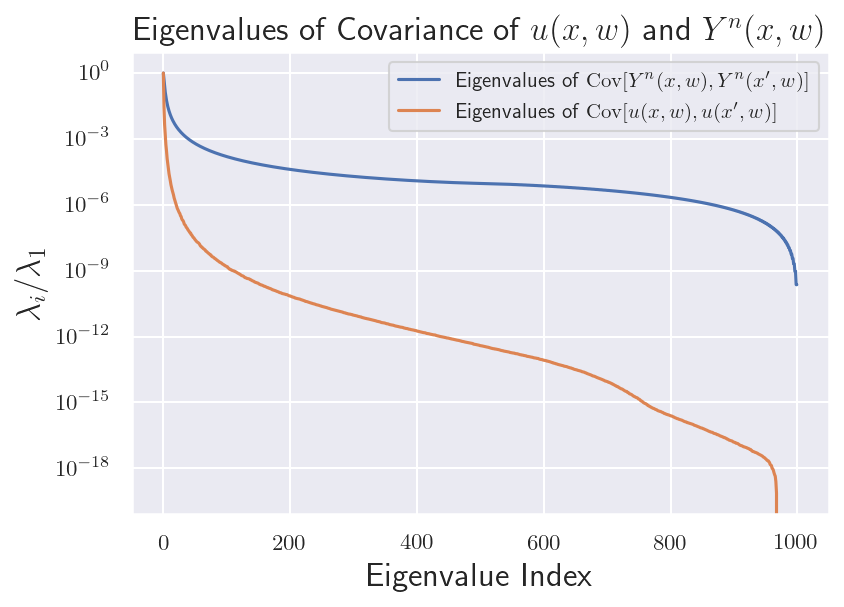

In [138]:
# Eigenvalues of Y(x,w)
_, eigval_Y, _, _ = nystrom(n)
eigval_Y = eigval_Y / eigval_Y[0]

# eigenvalues of u(x,w)
eigval_u = eigh(ucov, eigvals_only=True)
idx = eigval_u.argsort()[::-1]
eigval_u = eigval_u[idx]
eigval_u = eigval_u / eigval_u[0]

plt.figure(figsize=(6,4), dpi=150)
plt.semilogy(eigval_Y, label=r"Eigenvalues of $\mathrm{Cov}[Y^n(x,w),Y^n(x^{\prime},w)]$")
plt.semilogy(eigval_u, label=r"Eigenvalues of $\mathrm{Cov}[u(x,w),u(x^{\prime},w)]$")
plt.xlabel("Eigenvalue Index", fontsize=16)
plt.ylabel(r"$\lambda_i / \lambda_1$", fontsize=16)
plt.title(r"Eigenvalues of Covariance of $u(x,w)$ and $Y^n(x,w)$", fontsize=16)
plt.legend(prop={'size': 10})

<!-- ## 3.2.(c) -->

We compute the estimate of the sensitivity indices with Saltelli method as before. We use 5000 samples here.

In [145]:
# Monte Carlo
# params
np.random.seed(2)
n = 1000
s = 1000
r = 5
p = 1
xgrid = np.linspace(0,1,1001)

# truncated
Ur = sde_mc(n,s,xgrid,option='tKL', r=r)

# build Saltelli matrices
KA, A = sample_pce_kl(n,r,s,p,xgrid)
KA = KA.T
flux_A = draw_flux(s).reshape(-1,1)
A = np.hstack((A,flux_A))
KFA = np.hstack((KA,flux_A))

KB, B = sample_pce_kl(n,r,s,p,xgrid)
KB = KB.T
flux_B = draw_flux(s).reshape(-1,1)
B = np.hstack((B,flux_B))
KFB = np.hstack((KB,flux_B))

C_flux = KFB.copy()
C_flux[:,-1] = KFA[:,-1]
C_diff = KFB.copy()
C_diff[:,:-1] = KFA[:,:-1]

# simulate SDE
U_A = sde_mc(n,s,xgrid,KF=KFA)
U_B = sde_mc(n,s,xgrid,KF=KFB)
U_Cflux = sde_mc(n,s,xgrid,KF=C_flux)
U_Cdiff = sde_mc(n,s,xgrid,KF=C_diff)

# build Vandermonde matrix
VA = build_V(s,r+1,p,A)
VB = build_V(s,r+1,p,B)
Vflux = build_V(s,r+1,p,C_flux)
Vdiff = build_V(s,r+1,p,C_diff)

# record polynomial coefficients
cmat_A = np.zeros((VA.shape[1],xgrid.shape[0]))
for idx,x in enumerate(xgrid):

    # build LS problem
    fA = U_A[idx,:]

    # solve LS problem
    cmat_A[:,idx] = np.linalg.lstsq(VA, fA, rcond=None)[0]

# approximate u(x,w)
U_samples_A = VA @ cmat_A
U_samples_A = U_samples_A.T
UA05 = U_samples_A[500,:]

cmat_B = np.zeros((VB.shape[1],xgrid.shape[0]))
for idx,x in enumerate(xgrid):

    # build LS problem
    fB = U_B[idx,:]

    # solve LS problem
    cmat_B[:,idx] = np.linalg.lstsq(VB, fB, rcond=None)[0]

# approximate u(x,w)
U_samples_B = VB @ cmat_B
U_samples_B = U_samples_B.T
UB05 = U_samples_B[500,:]


cmat_flux = np.zeros((Vflux.shape[1],xgrid.shape[0]))
for idx,x in enumerate(xgrid):

    # build LS problem
    fflux = U_Cflux[idx,:]

    # solve LS problem
    cmat_flux[:,idx] = np.linalg.lstsq(Vflux, fflux, rcond=None)[0]

# approximate u(x,w)
U_samples_flux = Vflux @ cmat_flux
U_samples_flux = U_samples_flux.T
UCflux05 = U_samples_flux[500,:]


cmat_diff = np.zeros((Vdiff.shape[1],xgrid.shape[0]))
for idx,x in enumerate(xgrid):

    # build LS problem
    fdiff = U_Cdiff[idx,:]

    # solve LS problem
    cmat_diff[:,idx] = np.linalg.lstsq(Vdiff, fdiff, rcond=None)[0]

# approximate u(x,w)
U_samples_diff = Vdiff @ cmat_diff
U_samples_diff = U_samples_diff.T
UCdiff05 = U_samples_diff[500,:]


f0sq = np.mean(UA05) **2
S_flux_main = (np.mean(UA05 * UCflux05) - f0sq) / (np.mean(UA05 **2) - f0sq)
S_flux_total = 1 - (np.mean(UB05 * UCflux05) - f0sq) / (np.mean(UA05 **2) - f0sq)
S_diff_main = (np.mean(UA05 * UCdiff05) - f0sq) / (np.mean(UA05 **2) - f0sq)
S_diff_total = 1 - (np.mean(UB05 * UCdiff05) - f0sq) / (np.mean(UA05 **2) - f0sq)

print("Flux Main Index:", S_flux_main)
print("Flux Total Index:", S_flux_total)
print("Diffusivity Main Index:", S_diff_main)
print("Diffusivity Total Index:", S_diff_total)

Flux Main Index: 0.10740706661810996
Flux Total Index: -2.047033375223046
Diffusivity Main Index: 0.09455386242668712
Diffusivity Total Index: 1.8278208100409903


We see that the sensitivity indices of the diffusivity is bigger than those of the flux, which means the diffusivity is more influential to the solution than the flux. More samples are needed to better understand the sensitivity, but due to limited computational resources, we will stick with the result presented here.

#